In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Gradients Parcelwise PLS

In [2]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships.

This script:
1. Loads gradient CSVs (one per gradient).
2. Filters to patient groups (diagnosis 2 = bipolar, 3 = schizophrenia).
3. Encodes categorical vars numerically (gender, diagnosis).
4. Z-scores individual cognitive tests before averaging into domains.
5. Inverts cognitive domain scores (higher = worse performance).
6. Regresses out age and gender from brain features (X).
7. Z-scores both X and Y before PLS.
8. Fits PLS and extracts saliences (x_weights_, y_weights_), scores, and behavior–LV correlations.
9. Stores results in a dictionary and prints summaries.

"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']

# Covariates to regress out from brain features
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------

def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


def regress_out(X, covariates):
    """
    Regress out confounding variables (e.g., age, gender) from each column of X.
    X: n × p data matrix
    covariates: n × k matrix of confound variables
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


# ------------------------
# Main analysis
# ------------------------
results = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns (assuming node_1 ... node_400)
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        # Z-score each cognitive variable before averaging
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score = zscored.mean(axis=1)

        # Invert so higher = worse
        patient_df[group_name] = -domain_score

    # Combine behavioral + clinical variables (Y)
    Y_cols = other_vars + list(group_definitions.keys())
    Y = patient_df[Y_cols].values

    # ------------------------
    # Remove any subjects with missing data in X or Y
    # ------------------------
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid_mask = ~(nan_rows_X | nan_rows_Y)

    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # ------------------------
    # Regress out age and gender from X (per voxel)
    # ------------------------
    covars = patient_df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # ------------------------
    # Standardize (z-score) both X and Y (column-wise)
    # ------------------------
    # Standardize
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # ------------------------
    # Fit Partial Least Squares (PLS)
    # ------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Saliences (weights) for X and Y
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # Subject scores (how much each subject expresses the LV pattern)
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]

    # Correlate each behavioral variable with the LV behavioral score
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        corr, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = corr

    # ------------------------
    # Save results
    # ------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std': X_std,   # standardized brain data
        'Y_std': Y_std    # standardized behavioral data
    }

    # ------------------------
    # Print summary
    # ------------------------
    print(f"{grad_name} behavioral correlations (higher = worse severity):")
    for var, corr in behav_corrs.items():
        print(f"  {var:25s}: {corr:6.3f}")

# ------------------------
# End of pipeline
# ------------------------
print("\nAll gradients processed. Results stored in `results` dict.")



--- Processing G1 ---
G1 behavioral correlations (higher = worse severity):
  diagnosis                :  0.799
  SAPSDisorganization      : -0.517
  Amotivation              : -0.581
  DimEx                    : -0.522
  SAPSPositiveSymptoms     : -0.821
  hamilton_21              : -0.193
  YMRS                     : -0.178
  Attention_WorkingMemory  : -0.556
  VerbalLearning_Memory    : -0.575
  Reasoning_ProblemSolving : -0.561
  Verbal_Comprehension     : -0.560

--- Processing G2 ---
G2 behavioral correlations (higher = worse severity):
  diagnosis                :  0.784
  SAPSDisorganization      : -0.484
  Amotivation              : -0.581
  DimEx                    : -0.530
  SAPSPositiveSymptoms     : -0.822
  hamilton_21              : -0.229
  YMRS                     : -0.165
  Attention_WorkingMemory  : -0.581
  VerbalLearning_Memory    : -0.586
  Reasoning_ProblemSolving : -0.561
  Verbal_Comprehension     : -0.565

--- Processing G3 ---
G3 behavioral correlations (hig

## Cortical projection of loadings

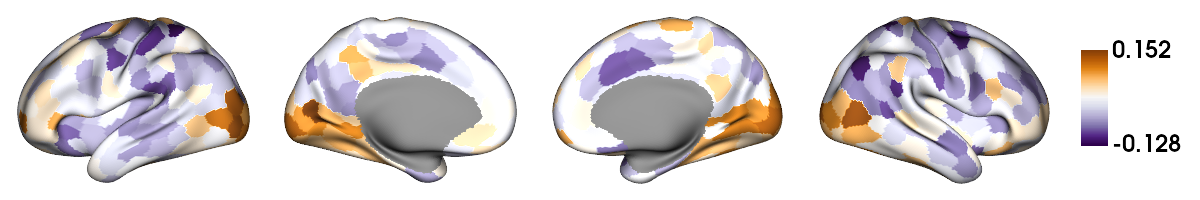

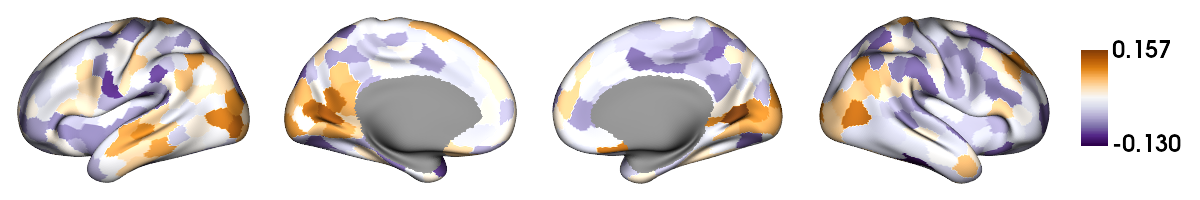

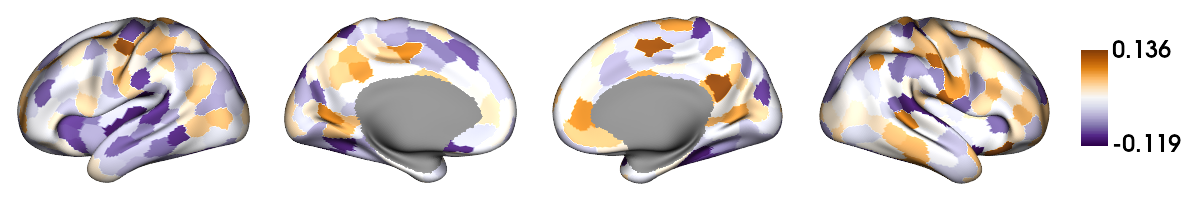

In [3]:
from IPython.display import Image, display
import numpy as np

for grad_name in results.keys():
    X_saliences = results[grad_name]['X_saliences']
    
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j+1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan

    filename = f'./new_figures/{grad_name}_LC1_map_cortex.png'
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # save instead of interactive window
        filename=filename
    )
    display(Image(filename))


## Permutation testing

In [4]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized X and Y
    X = results[grad_name]['X_std']  # standardized X (brain data)
    Y = results[grad_name]['Y_std']  # standardized Y (behavioral data)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X
        X_perm = X[np.random.permutation(X.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)
        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]
        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")



Permutation testing for G1...
G1 LV1 permutation p-value: 0.0563
Permutation testing for G2...
G2 LV1 permutation p-value: 0.5509
Permutation testing for G3...
G3 LV1 permutation p-value: 0.8194


## Bootstrap resampling

Bootstrap resampling for G1...


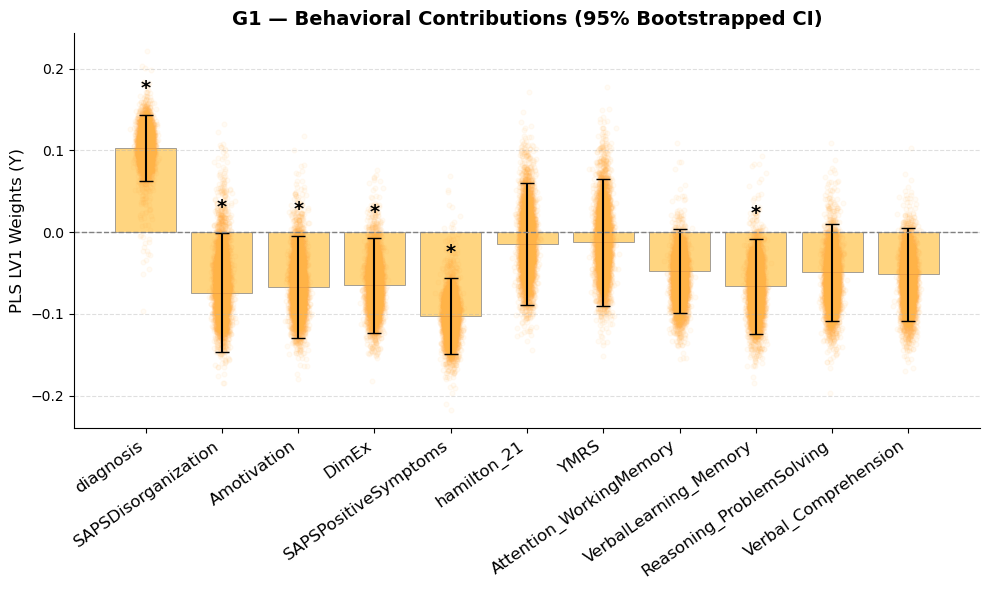

Bootstrap resampling for G2...


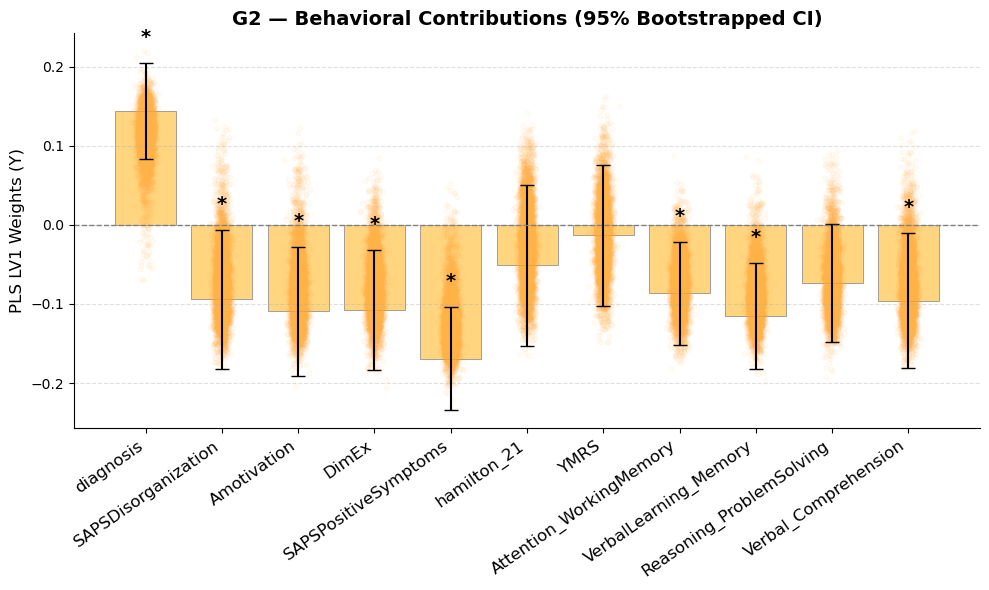

Bootstrap resampling for G3...


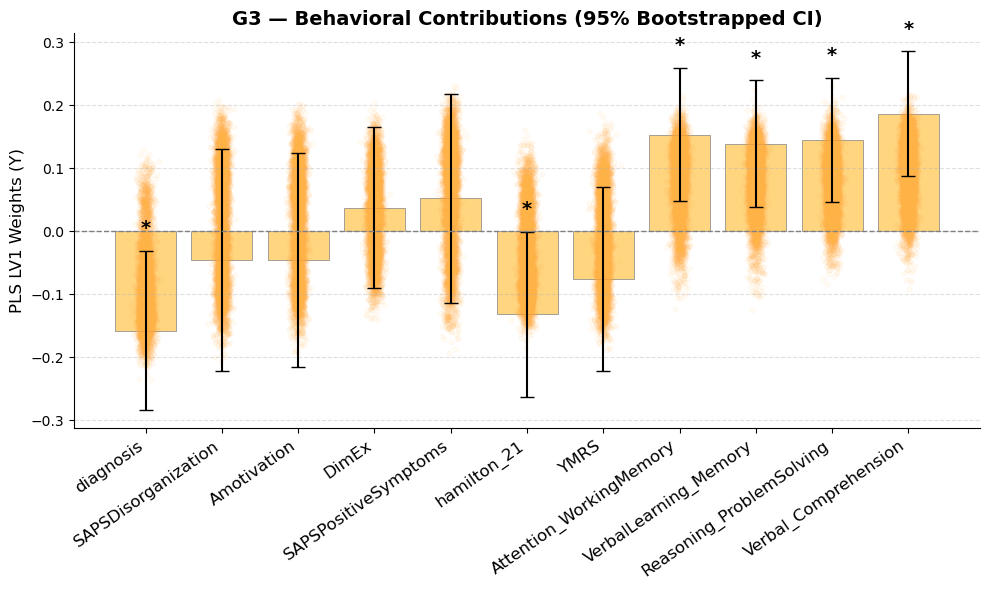

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap ratios

# Color palette for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Standardized X and Y
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------

        # Align bootstrap LV1 with original LV1
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    
    # Mean and 95% CI
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10,6))

    # Bars with error bars
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=0.8,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained

Computing variance explained for G1...
  LV1 explains 8.90% of X variance, 11.08% of Y variance, and 14.98% shared variance.

Computing variance explained for G2...
  LV1 explains 5.11% of X variance, 15.05% of Y variance, and 4.33% shared variance.

Computing variance explained for G3...
  LV1 explains 3.81% of X variance, 14.76% of Y variance, and 2.50% shared variance.



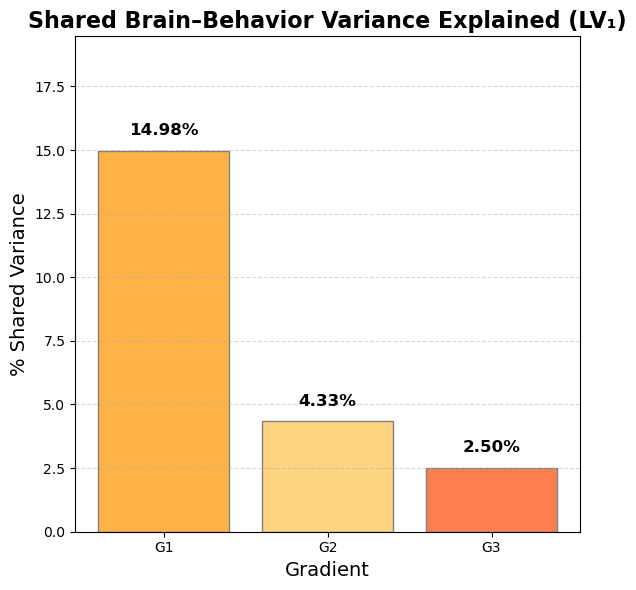

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

var_explained_dict = {}

for grad_name, res in results.items():
    print(f"Computing variance explained for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    # Reconstruct predicted X and Y
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained within each block
    var_X = np.var(X, axis=0).sum()
    var_Y = np.var(Y, axis=0).sum()
    var_X_expl = np.var(X_pred, axis=0).sum() / var_X
    var_Y_expl = np.var(Y_pred, axis=0).sum() / var_Y

    # Shared cross-covariance variance explained
    shared_var = (pls.x_scores_.T @ pls.y_scores_)**2 / (np.sum(X**2) * np.sum(Y**2))
    shared_var = shared_var.item() 

    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var'] = shared_var

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared%': shared_var * 100
    }

    print(f"  LV1 explains {var_X_expl * 100:.2f}% of X variance, "
          f"{var_Y_expl * 100:.2f}% of Y variance, "
          f"and {shared_var * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
grad_names = list(var_explained_dict.keys())
vals = [v['Shared%'] for v in var_explained_dict.values()]

plt.figure(figsize=(6, 6))
bars = plt.bar(grad_names, vals, color=['#FFB347', '#FFD580', '#FF7F50'], edgecolor='gray')

for i, v in enumerate(vals):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(vals) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1.png", dpi=300)
plt.show()


## Cross validation


Cross-validating G1...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.296


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.0220

Cross-validating G2...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.089
  → Cross-validated correlation p-value = 0.3210

Cross-validating G3...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = -0.203
  → Cross-validated correlation p-value = 0.8580


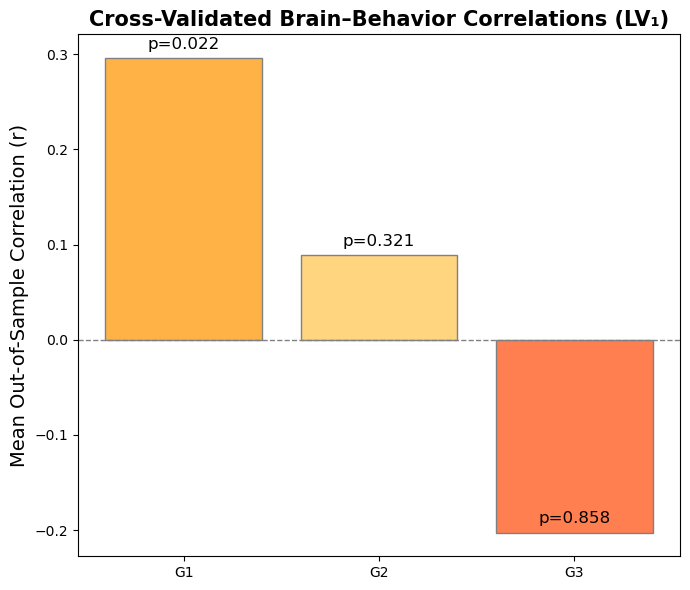

In [7]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits = 5        # for larger samples
n_repeats = 20      # number of random splits for KFold
n_perm = 1000       # number of permutations
random_state = 42

cv_results = {}

# --------------------------------------------------
# CROSS-VALIDATION LOOP
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nCross-validating {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    # Choose CV strategy automatically
    if n < 80:
        print(f"  Small sample detected (n={n}) → using Leave-One-Out CV.")
        use_loocv = True
        n_repeats_eff = 1
    else:
        print(f"  Using {n_splits}-fold CV with {n_repeats} repeats.")
        use_loocv = False
        n_repeats_eff = n_repeats

    # ---------------------------
    # Collect predicted scores
    # ---------------------------
    all_x_pred = np.zeros(n)
    all_y_pred = np.zeros(n)

    if use_loocv:
        # LOOCV
        for test_idx in range(n):
            train_idx = np.setdiff1d(np.arange(n), test_idx)
            pls = PLSRegression(n_components=1)
            pls.fit(X[train_idx], Y[train_idx])

            all_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
            all_y_pred[test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
    else:
        # KFold repeated CV
        temp_x_pred = np.zeros((n_repeats_eff, n))
        temp_y_pred = np.zeros((n_repeats_eff, n))

        for rep in range(n_repeats_eff):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
            for train_idx, test_idx in kf.split(X):
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y[train_idx])
                temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                temp_y_pred[rep, test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
        # Average across repeats
        all_x_pred = temp_x_pred.mean(axis=0)
        all_y_pred = temp_y_pred.mean(axis=0)

    # ---------------------------
    # Compute observed correlation
    # ---------------------------
    observed_r, _ = pearsonr(all_x_pred, all_y_pred)
    print(f"  Observed out-of-sample correlation: r = {observed_r:.3f}")

    # ---------------------------
    # Permutation testing
    # ---------------------------
    perm_corrs = []
    for perm in range(n_perm):
        Y_perm = Y[np.random.permutation(n)]

        if use_loocv:
            perm_x_pred = np.zeros(n)
            perm_y_pred = np.zeros(n)
            for test_idx in range(n):
                train_idx = np.setdiff1d(np.arange(n), test_idx)
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y_perm[train_idx])
                perm_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                perm_y_pred[test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
        else:
            temp_x_pred = np.zeros((n_repeats_eff, n))
            temp_y_pred = np.zeros((n_repeats_eff, n))
            for rep in range(n_repeats_eff):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                for train_idx, test_idx in kf.split(X):
                    pls = PLSRegression(n_components=1)
                    pls.fit(X[train_idx], Y_perm[train_idx])
                    temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                    temp_y_pred[rep, test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
            perm_x_pred = temp_x_pred.mean(axis=0)
            perm_y_pred = temp_y_pred.mean(axis=0)

        r_perm, _ = pearsonr(perm_x_pred, perm_y_pred)
        perm_corrs.append(r_perm)

    perm_corrs = np.array(perm_corrs)
    pval = np.mean(perm_corrs >= observed_r)

    cv_results[grad_name] = {
        'observed_r': observed_r,
        'perm_corrs': perm_corrs,
        'pval': pval
    }

    print(f"  → Cross-validated correlation p-value = {pval:.4f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars = plt.bar(cv_results.keys(),
               [cv_results[g]['observed_r'] for g in cv_results],
               color=['#FFB347', '#FFD580', '#FF7F50'],
               edgecolor='gray')
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁)", fontsize=15, fontweight='bold')

for i, g in enumerate(cv_results.keys()):
    r = cv_results[g]['observed_r']
    p = cv_results[g]['pval']
    plt.text(i, r + 0.01, f"p={p:.3f}", ha='center', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("new_figures/cv_out_of_sample_correlations.png", dpi=300)
plt.show()


## Split half resampling

In [8]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

n_splits = 100  # number of random split-half resamplings
stability_results = {}

for grad_name, res in results.items():
    print(f"\nSplit-half resampling for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    brain_corrs = []
    behav_corrs = []

    for split in range(n_splits):
        # Random split
        idx = np.random.permutation(n)
        half = n // 2
        idx1, idx2 = idx[:half], idx[half:]

        # PLS on first half
        pls1 = PLSRegression(n_components=1)
        pls1.fit(X[idx1], Y[idx1])
        U1 = pls1.x_weights_[:, 0]
        V1 = pls1.y_weights_[:, 0]

        # PLS on second half
        pls2 = PLSRegression(n_components=1)
        pls2.fit(X[idx2], Y[idx2])
        U2 = pls2.x_weights_[:, 0]
        V2 = pls2.y_weights_[:, 0]

        # Align signs
        if np.dot(U1, U2) < 0:
            U2 *= -1
            V2 *= -1

        # Compute correlation
        brain_corrs.append(np.corrcoef(U1, U2)[0, 1])
        behav_corrs.append(np.corrcoef(V1, V2)[0, 1])

    stability_results[grad_name] = {
        'brain_stability': np.mean(brain_corrs),
        'behav_stability': np.mean(behav_corrs),
        'brain_corrs_all': brain_corrs,
        'behav_corrs_all': behav_corrs
    }

    print(f"  Brain pattern stability (mean r): {stability_results[grad_name]['brain_stability']:.3f}")
    print(f"  Behavioral pattern stability (mean r): {stability_results[grad_name]['behav_stability']:.3f}")



Split-half resampling for G1...
  Brain pattern stability (mean r): 0.304
  Behavioral pattern stability (mean r): 0.732

Split-half resampling for G2...
  Brain pattern stability (mean r): 0.104
  Behavioral pattern stability (mean r): 0.328

Split-half resampling for G3...
  Brain pattern stability (mean r): 0.071
  Behavioral pattern stability (mean r): -0.262


# PLS without diagnosis 

In [9]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships.

This script:
1. Loads gradient CSVs (one per gradient).
2. Filters to patient groups (diagnosis 2 = bipolar, 3 = schizophrenia).
3. Encodes categorical vars numerically (gender, diagnosis).
4. Z-scores individual cognitive tests before averaging into domains.
5. Inverts cognitive domain scores (higher = worse performance).
6. Regresses out age and gender from brain features (X).
7. Z-scores both X and Y before PLS.
8. Fits PLS and extracts saliences (x_weights_, y_weights_), scores, and behavior–LV correlations.
9. Stores results in a dictionary and prints summaries.

Author: [Your Name]
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include
other_vars = ['SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']

# Covariates to regress out from brain features
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------

def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


def regress_out(X, covariates):
    """
    Regress out confounding variables (e.g., age, gender) from each column of X.
    X: n × p data matrix
    covariates: n × k matrix of confound variables
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


# ------------------------
# Main analysis
# ------------------------
results = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        # Z-score each cognitive variable before averaging
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score = zscored.mean(axis=1)

        # Invert so higher = worse
        patient_df[group_name] = -domain_score

    # Combine behavioral + clinical variables (Y)
    Y_cols = other_vars + list(group_definitions.keys())
    Y = patient_df[Y_cols].values

    # ------------------------
    # Remove any subjects with missing data in X or Y
    # ------------------------
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid_mask = ~(nan_rows_X | nan_rows_Y)

    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # ------------------------
    # Regress out age and gender from X (per voxel)
    # ------------------------
    covars = patient_df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # ------------------------
    # Standardize (z-score) both X and Y (column-wise)
    # ------------------------
    # Standardize
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # ------------------------
    # Fit Partial Least Squares (PLS)
    # ------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Saliences (weights) for X and Y
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # Subject scores (how much each subject expresses the LV pattern)
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]

    # Correlate each behavioral variable with the LV behavioral score
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        corr, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = corr

    # ------------------------
    # Save results
    # ------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std': X_std,   # standardized brain data
        'Y_std': Y_std    # standardized behavioral data
    }

    # ------------------------
    # Print summary
    # ------------------------
    print(f"{grad_name} behavioral correlations (higher = worse severity):")
    for var, corr in behav_corrs.items():
        print(f"  {var:25s}: {corr:6.3f}")

# ------------------------
# End of pipeline
# ------------------------
print("\nAll gradients processed. Results stored in `results` dict.")



--- Processing G1 ---
G1 behavioral correlations (higher = worse severity):
  SAPSDisorganization      : -0.579
  Amotivation              : -0.641
  DimEx                    : -0.517
  SAPSPositiveSymptoms     : -0.785
  hamilton_21              : -0.287
  YMRS                     : -0.273
  Attention_WorkingMemory  : -0.568
  VerbalLearning_Memory    : -0.580
  Reasoning_ProblemSolving : -0.557
  Verbal_Comprehension     : -0.520

--- Processing G2 ---
G2 behavioral correlations (higher = worse severity):
  SAPSDisorganization      : -0.542
  Amotivation              : -0.647
  DimEx                    : -0.535
  SAPSPositiveSymptoms     : -0.794
  hamilton_21              : -0.330
  YMRS                     : -0.250
  Attention_WorkingMemory  : -0.582
  VerbalLearning_Memory    : -0.571
  Reasoning_ProblemSolving : -0.542
  Verbal_Comprehension     : -0.511

--- Processing G3 ---
G3 behavioral correlations (higher = worse severity):
  SAPSDisorganization      :  0.666
  Amotivation

## Cortical projection

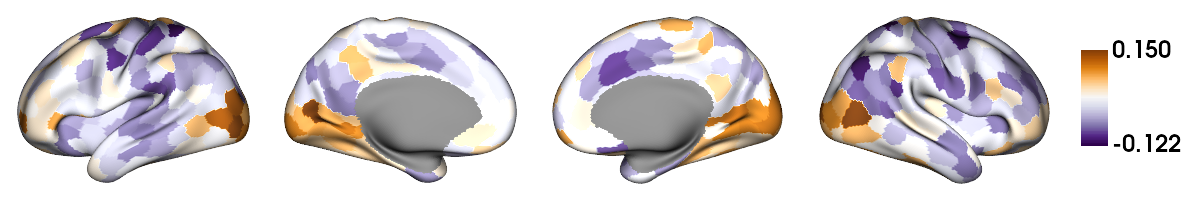

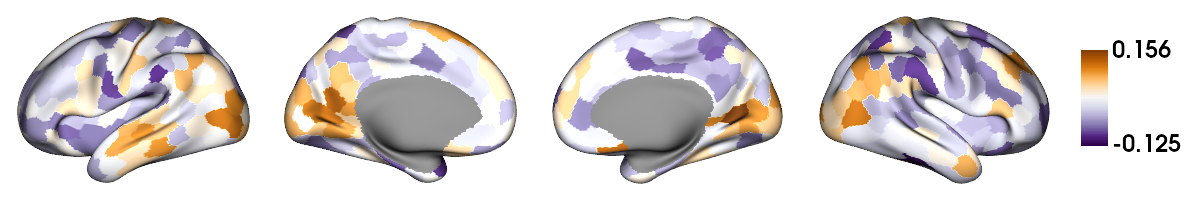

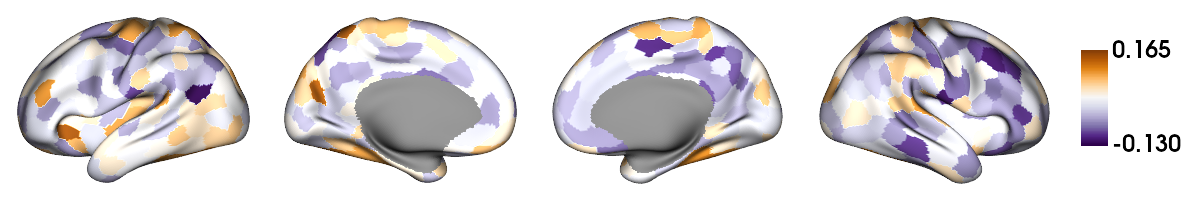

In [10]:
from IPython.display import Image, display
import numpy as np

for grad_name in results.keys():
    X_saliences = results[grad_name]['X_saliences']
    
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j+1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan

    filename = f'./new_figures/{grad_name}_LC1_map_cortex.png'
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # save instead of interactive window
        filename=filename
    )
    display(Image(filename))


## Permutation testing

In [11]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized X and Y 
    X = results[grad_name]['X_std']  # standardized X (brain data)
    Y = results[grad_name]['Y_std']  # standardized Y (behavioral data)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X
        X_perm = X[np.random.permutation(X.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)
        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]
        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")



Permutation testing for G1...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


G1 LV1 permutation p-value: 0.0965
Permutation testing for G2...
G2 LV1 permutation p-value: 0.6193
Permutation testing for G3...
G3 LV1 permutation p-value: 0.7186


## Bootstrap resampling

Bootstrap resampling for G1...


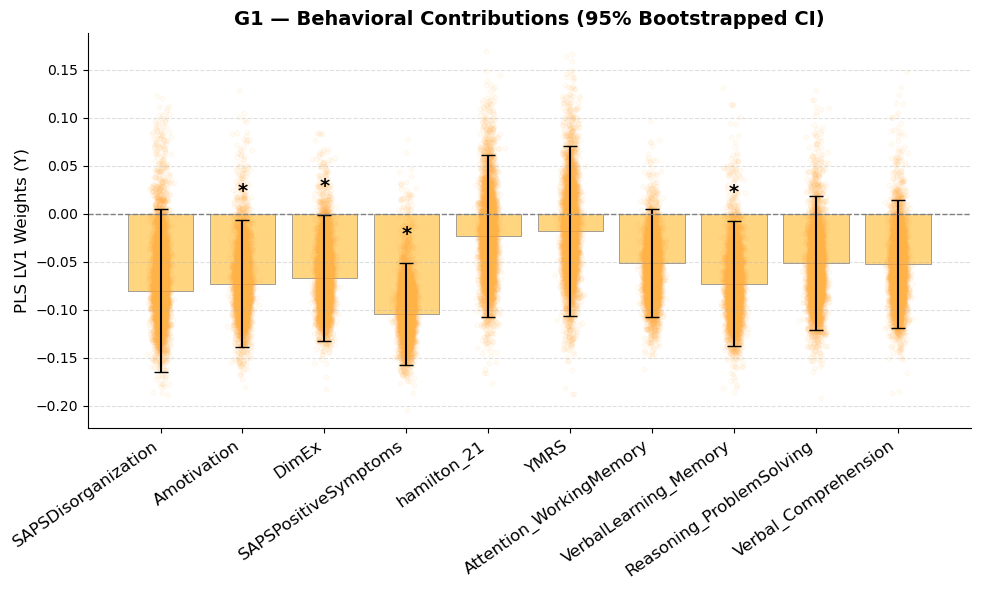

Bootstrap resampling for G2...


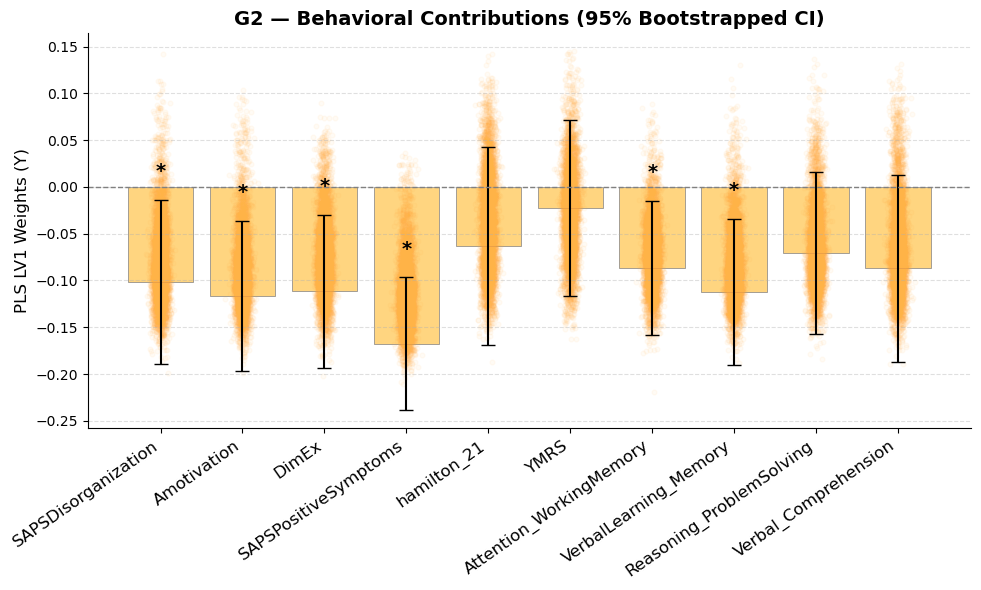

Bootstrap resampling for G3...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


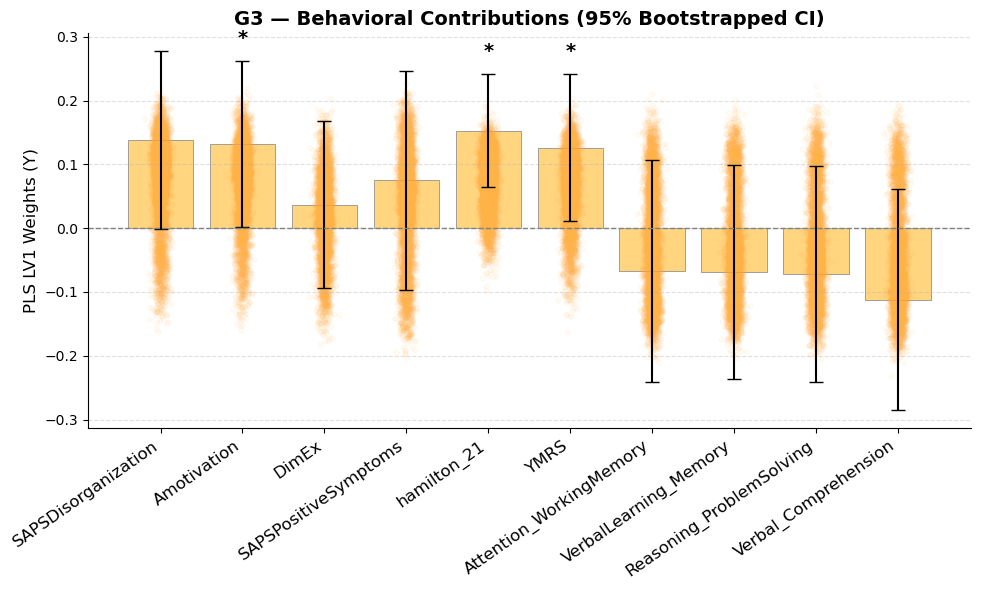

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap ratios

# Color palette for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Standardized X and Y
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------
        # Align bootstrap LV1 with original LV1
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    
    # Mean and 95% CI
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10,6))

    # Bars with error bars
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=0.8,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained

Computing variance explained for G1...
  LV1 explains 8.83% of X variance, 10.12% of Y variance, and 15.10% shared variance.

Computing variance explained for G2...
  LV1 explains 5.07% of X variance, 14.00% of Y variance, and 4.74% shared variance.

Computing variance explained for G3...
  LV1 explains 4.15% of X variance, 13.31% of Y variance, and 3.67% shared variance.



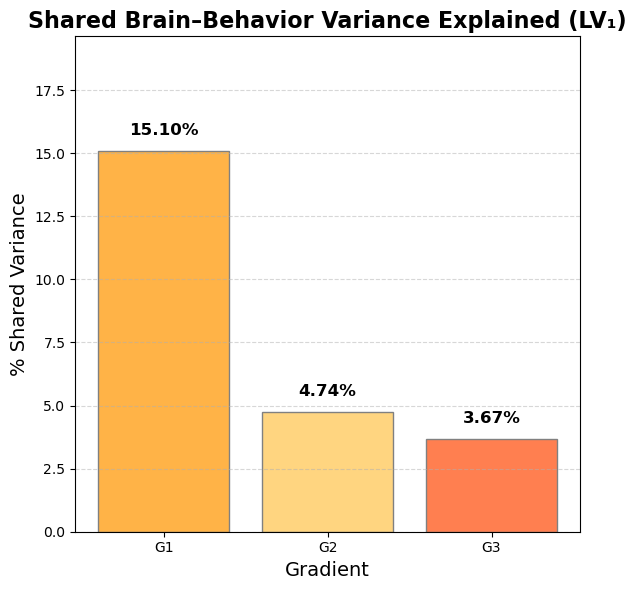

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

var_explained_dict = {}

for grad_name, res in results.items():
    print(f"Computing variance explained for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    # Reconstruct predicted X and Y
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained within each block
    var_X = np.var(X, axis=0).sum()
    var_Y = np.var(Y, axis=0).sum()
    var_X_expl = np.var(X_pred, axis=0).sum() / var_X
    var_Y_expl = np.var(Y_pred, axis=0).sum() / var_Y

    # Shared cross-covariance variance explained
    shared_var = (pls.x_scores_.T @ pls.y_scores_)**2 / (np.sum(X**2) * np.sum(Y**2))
    shared_var = shared_var.item() 

    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var'] = shared_var

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared%': shared_var * 100
    }

    print(f"  LV1 explains {var_X_expl * 100:.2f}% of X variance, "
          f"{var_Y_expl * 100:.2f}% of Y variance, "
          f"and {shared_var * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
grad_names = list(var_explained_dict.keys())
vals = [v['Shared%'] for v in var_explained_dict.values()]

plt.figure(figsize=(6, 6))
bars = plt.bar(grad_names, vals, color=['#FFB347', '#FFD580', '#FF7F50'], edgecolor='gray')

for i, v in enumerate(vals):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(vals) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1.png", dpi=300)
plt.show()


## Cross validation


Cross-validating G1...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.255
  → Cross-validated correlation p-value = 0.0500

Cross-validating G2...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.060


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.4170

Cross-validating G3...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.072
  → Cross-validated correlation p-value = 0.4030


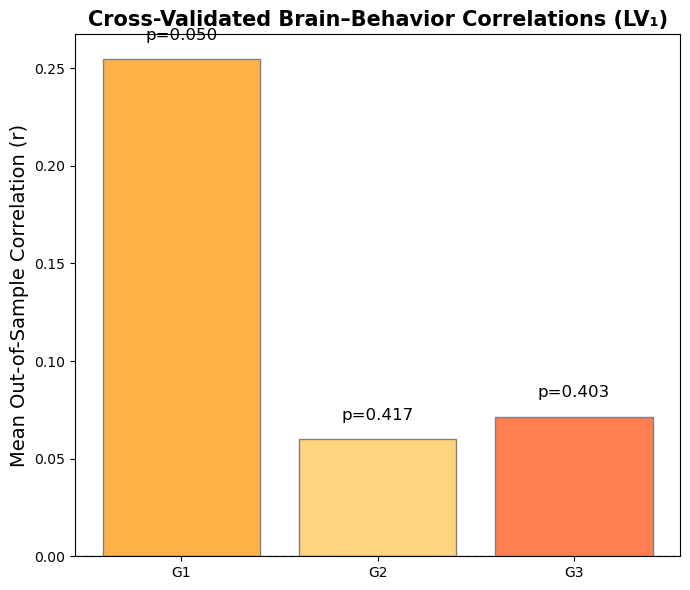

In [14]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits = 5        # for larger samples
n_repeats = 20      # number of random splits for KFold
n_perm = 1000       # number of permutations
random_state = 42

cv_results = {}

# --------------------------------------------------
# CROSS-VALIDATION LOOP
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nCross-validating {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    # Choose CV strategy automatically
    if n < 80:
        print(f"  Small sample detected (n={n}) → using Leave-One-Out CV.")
        use_loocv = True
        n_repeats_eff = 1
    else:
        print(f"  Using {n_splits}-fold CV with {n_repeats} repeats.")
        use_loocv = False
        n_repeats_eff = n_repeats

    # ---------------------------
    # Collect predicted scores
    # ---------------------------
    all_x_pred = np.zeros(n)
    all_y_pred = np.zeros(n)

    if use_loocv:
        # LOOCV
        for test_idx in range(n):
            train_idx = np.setdiff1d(np.arange(n), test_idx)
            pls = PLSRegression(n_components=1)
            pls.fit(X[train_idx], Y[train_idx])

            all_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
            all_y_pred[test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
    else:
        # KFold repeated CV
        temp_x_pred = np.zeros((n_repeats_eff, n))
        temp_y_pred = np.zeros((n_repeats_eff, n))

        for rep in range(n_repeats_eff):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
            for train_idx, test_idx in kf.split(X):
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y[train_idx])
                temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                temp_y_pred[rep, test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
        # Average across repeats
        all_x_pred = temp_x_pred.mean(axis=0)
        all_y_pred = temp_y_pred.mean(axis=0)

    # ---------------------------
    # Compute observed correlation
    # ---------------------------
    observed_r, _ = pearsonr(all_x_pred, all_y_pred)
    print(f"  Observed out-of-sample correlation: r = {observed_r:.3f}")

    # ---------------------------
    # Permutation testing
    # ---------------------------
    perm_corrs = []
    for perm in range(n_perm):
        Y_perm = Y[np.random.permutation(n)]

        if use_loocv:
            perm_x_pred = np.zeros(n)
            perm_y_pred = np.zeros(n)
            for test_idx in range(n):
                train_idx = np.setdiff1d(np.arange(n), test_idx)
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y_perm[train_idx])
                perm_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                perm_y_pred[test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
        else:
            temp_x_pred = np.zeros((n_repeats_eff, n))
            temp_y_pred = np.zeros((n_repeats_eff, n))
            for rep in range(n_repeats_eff):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                for train_idx, test_idx in kf.split(X):
                    pls = PLSRegression(n_components=1)
                    pls.fit(X[train_idx], Y_perm[train_idx])
                    temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                    temp_y_pred[rep, test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
            perm_x_pred = temp_x_pred.mean(axis=0)
            perm_y_pred = temp_y_pred.mean(axis=0)

        r_perm, _ = pearsonr(perm_x_pred, perm_y_pred)
        perm_corrs.append(r_perm)

    perm_corrs = np.array(perm_corrs)
    pval = np.mean(perm_corrs >= observed_r)

    cv_results[grad_name] = {
        'observed_r': observed_r,
        'perm_corrs': perm_corrs,
        'pval': pval
    }

    print(f"  → Cross-validated correlation p-value = {pval:.4f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars = plt.bar(cv_results.keys(),
               [cv_results[g]['observed_r'] for g in cv_results],
               color=['#FFB347', '#FFD580', '#FF7F50'],
               edgecolor='gray')
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁)", fontsize=15, fontweight='bold')

for i, g in enumerate(cv_results.keys()):
    r = cv_results[g]['observed_r']
    p = cv_results[g]['pval']
    plt.text(i, r + 0.01, f"p={p:.3f}", ha='center', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("new_figures/cv_out_of_sample_correlations.png", dpi=300)
plt.show()


## Split half resampling

In [15]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

n_splits = 100  # number of random split-half resamplings
stability_results = {}

for grad_name, res in results.items():
    print(f"\nSplit-half resampling for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    brain_corrs = []
    behav_corrs = []

    for split in range(n_splits):
        # Random split
        idx = np.random.permutation(n)
        half = n // 2
        idx1, idx2 = idx[:half], idx[half:]

        # PLS on first half
        pls1 = PLSRegression(n_components=1)
        pls1.fit(X[idx1], Y[idx1])
        U1 = pls1.x_weights_[:, 0]
        V1 = pls1.y_weights_[:, 0]

        # PLS on second half
        pls2 = PLSRegression(n_components=1)
        pls2.fit(X[idx2], Y[idx2])
        U2 = pls2.x_weights_[:, 0]
        V2 = pls2.y_weights_[:, 0]

        # Align signs (optional, best practice)
        if np.dot(U1, U2) < 0:
            U2 *= -1
            V2 *= -1

        # Compute correlation
        brain_corrs.append(np.corrcoef(U1, U2)[0, 1])
        behav_corrs.append(np.corrcoef(V1, V2)[0, 1])

    stability_results[grad_name] = {
        'brain_stability': np.mean(brain_corrs),
        'behav_stability': np.mean(behav_corrs),
        'brain_corrs_all': brain_corrs,
        'behav_corrs_all': behav_corrs
    }

    print(f"  Brain pattern stability (mean r): {stability_results[grad_name]['brain_stability']:.3f}")
    print(f"  Behavioral pattern stability (mean r): {stability_results[grad_name]['behav_stability']:.3f}")



Split-half resampling for G1...
  Brain pattern stability (mean r): 0.267
  Behavioral pattern stability (mean r): 0.092

Split-half resampling for G2...
  Brain pattern stability (mean r): 0.083
  Behavioral pattern stability (mean r): 0.007

Split-half resampling for G3...
  Brain pattern stability (mean r): 0.094
  Behavioral pattern stability (mean r): 0.093


# Old analysis with diagnosis included

In [16]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships.

This script:
1. Loads gradient CSVs (one per gradient).
2. Filters to patient groups (diagnosis 2 = bipolar, 3 = schizophrenia).
3. Encodes categorical vars numerically (gender, diagnosis).
4. Z-scores individual cognitive tests before averaging into domains.
5. Inverts cognitive domain scores (higher = worse performance).
6. Regresses out age and gender from brain features (X).
7. Z-scores both X and Y before PLS.
8. Fits PLS and extracts saliences (x_weights_, y_weights_), scores, and behavior–LV correlations.
9. Stores results in a dictionary and prints summaries.

"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS', 'age']

# Covariates to regress out from brain features
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------

def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


def regress_out(X, covariates):
    """
    Regress out confounding variables (e.g., age, gender) from each column of X.
    X: n × p data matrix
    covariates: n × k matrix of confound variables
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


# ------------------------
# Main analysis
# ------------------------
results = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns (assuming node_1 ... node_400)
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        # Z-score each cognitive variable before averaging
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score = zscored.mean(axis=1)

        # Invert so higher = worse
        patient_df[group_name] = -domain_score

    # Combine behavioral + clinical variables (Y)
    Y_cols = other_vars + list(group_definitions.keys())
    Y = patient_df[Y_cols].values

    # ------------------------
    # Remove any subjects with missing data in X or Y
    # ------------------------
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid_mask = ~(nan_rows_X | nan_rows_Y)

    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # ------------------------
    # Regress out age and gender from X (per voxel)
    # ------------------------
    covars = patient_df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # ------------------------
    # Standardize (z-score) both X and Y (column-wise)
    # ------------------------
    # Standardize
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # ------------------------
    # Fit Partial Least Squares (PLS)
    # ------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Saliences (weights) for X and Y
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # Subject scores (how much each subject expresses the LV pattern)
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]

    # Correlate each behavioral variable with the LV behavioral score
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        corr, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = corr

    # ------------------------
    # Save results
    # ------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std': X_std,   # standardized brain data
        'Y_std': Y_std    # standardized behavioral data
    }

    # ------------------------
    # Print summary
    # ------------------------
    print(f"{grad_name} behavioral correlations (higher = worse severity):")
    for var, corr in behav_corrs.items():
        print(f"  {var:25s}: {corr:6.3f}")

# ------------------------
# End of pipeline
# ------------------------
print("\nAll gradients processed. Results stored in `results` dict.")



--- Processing G1 ---
G1 behavioral correlations (higher = worse severity):
  diagnosis                :  0.781
  SAPSDisorganization      : -0.514
  Amotivation              : -0.583
  DimEx                    : -0.500
  SAPSPositiveSymptoms     : -0.807
  hamilton_21              : -0.195
  YMRS                     : -0.198
  age                      : -0.294
  Attention_WorkingMemory  : -0.567
  VerbalLearning_Memory    : -0.582
  Reasoning_ProblemSolving : -0.593
  Verbal_Comprehension     : -0.554

--- Processing G2 ---
G2 behavioral correlations (higher = worse severity):
  diagnosis                :  0.780
  SAPSDisorganization      : -0.485
  Amotivation              : -0.583
  DimEx                    : -0.525
  SAPSPositiveSymptoms     : -0.820
  hamilton_21              : -0.232
  YMRS                     : -0.171
  age                      : -0.218
  Attention_WorkingMemory  : -0.583
  VerbalLearning_Memory    : -0.588
  Reasoning_ProblemSolving : -0.567
  Verbal_Comprehen

## Behavioral loadings 

Bootstrapping behavioral loadings for G1...


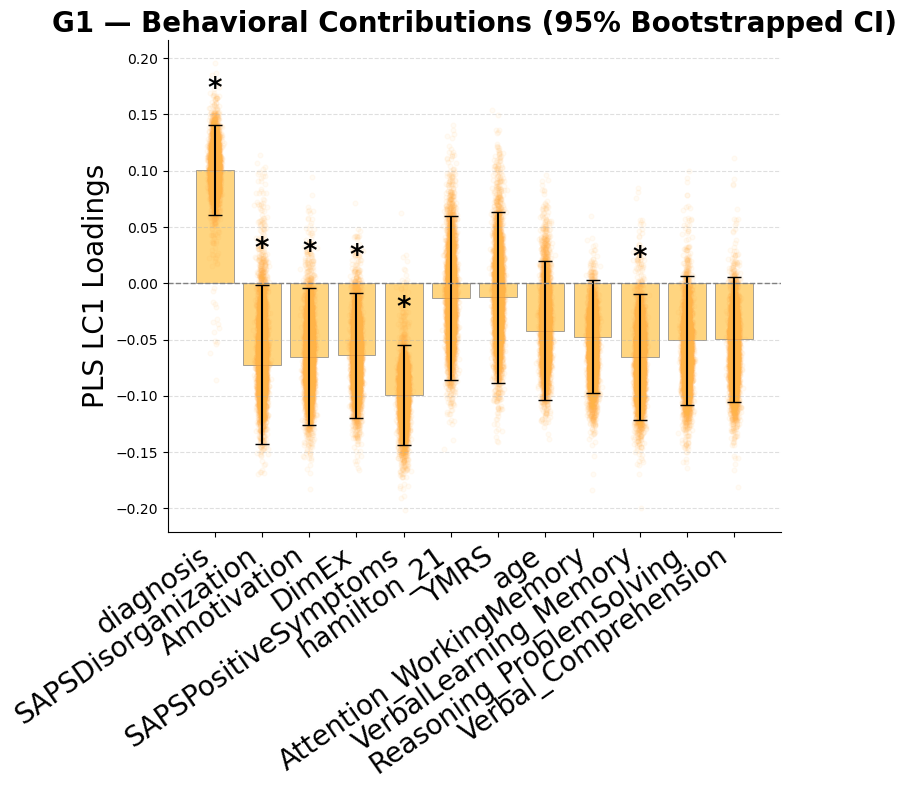

Bootstrapping behavioral loadings for G2...


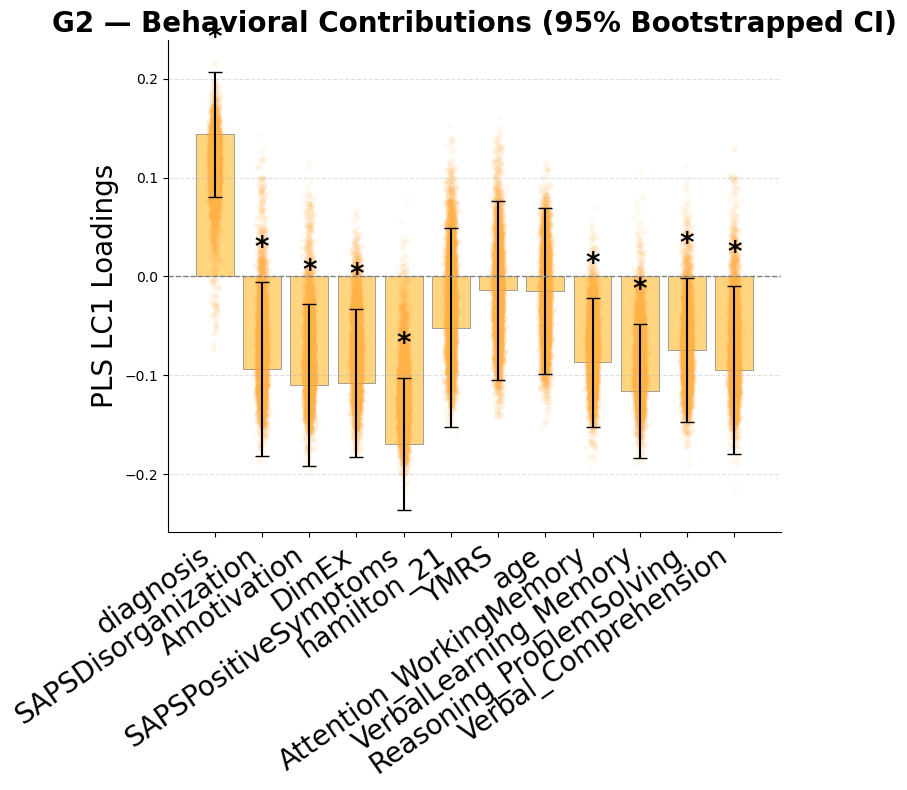

Bootstrapping behavioral loadings for G3...


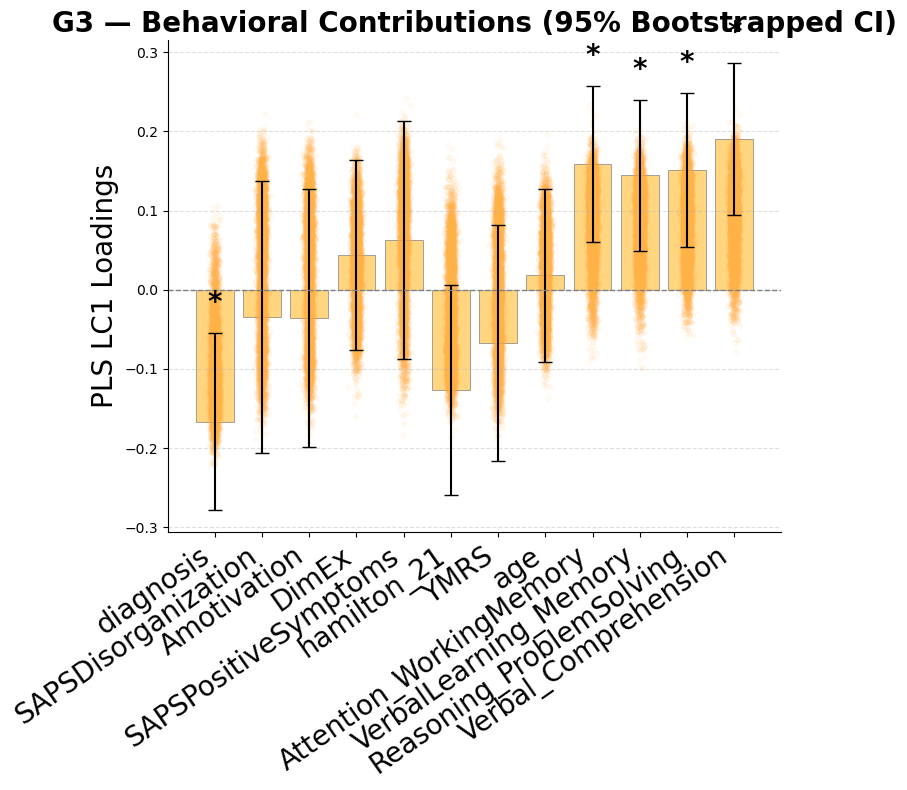

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

n_boot = 5000

# Color palette
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# Combine cortical and subcortical results
all_results = {**results}

for grad_name, res in all_results.items():
    print(f"Bootstrapping behavioral loadings for {grad_name}...")

    Y_cols = list(res['behav_corrs'].keys())
    feature_cols = [c for c in res['patient_df'].columns if c.startswith('node_') or c.startswith('sub_')]

    X_std = StandardScaler().fit_transform(res['patient_df'][feature_cols].values)
    Y_std = StandardScaler().fit_transform(res['patient_df'][Y_cols].values)

    Y_saliences = res['Y_saliences']
    n_behav = len(Y_cols)
    boot_y_saliences = np.zeros((n_boot, n_behav))

    # -------- Bootstrap --------
    for b in range(n_boot):
        idx = np.random.choice(len(X_std), size=len(X_std), replace=True)
        Xb = X_std[idx]
        Yb = Y_std[idx]

        plsb = PLSRegression(n_components=1)
        plsb.fit(Xb, Yb)
        yb = plsb.y_loadings_[:,0]

        if np.dot(yb, Y_saliences) < 0:
            yb *= -1
        boot_y_saliences[b, :] = yb

    # -------- Statistics --------
    y_mean = Y_saliences
    y_sd = boot_y_saliences.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd
    res['boot_y_saliences'] = boot_y_saliences
    res['lower_ci'] = lower_ci
    res['upper_ci'] = upper_ci
    res['significant'] = (lower_ci > 0) | (upper_ci < 0)


    # -------- Plot --------
    fig, ax = plt.subplots(figsize=(8,8))  # taller figure for near-square

    bar_width = 0.8  # thinner bars

    # Bars
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=bar_width,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for i in range(n_behav):
        y = boot_y_saliences[:,i]
        x = np.random.normal(i, 0.05, size=len(y))
        ax.scatter(x, y, color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for i in range(n_behav):
        if lower_ci[i] > 0 or upper_ci[i] < 0:
            ax.text(i, upper_ci[i] + 0.02, "*", ha='center', va='bottom',
                    fontsize=20, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=20)
    ax.set_ylabel('PLS LC1 Loadings', fontsize=20)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=20, fontweight='bold')

    # Grid and spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.savefig(f'new_figures/{grad_name}_loadings_barplot_thin.png', dpi=300)
    plt.show()



=== Processing G1 ===


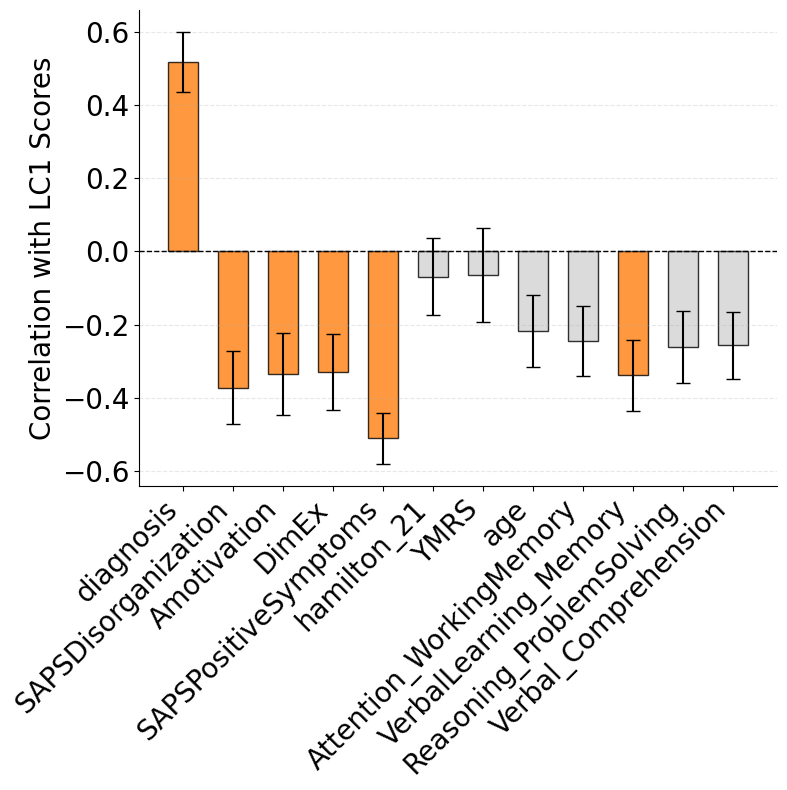


=== Processing G2 ===


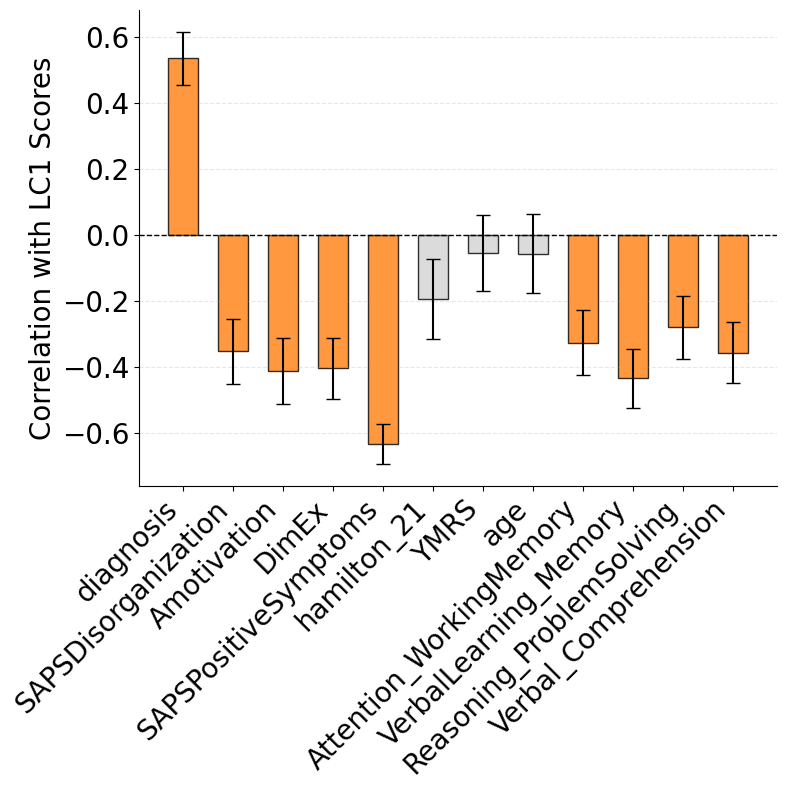


=== Processing G3 ===


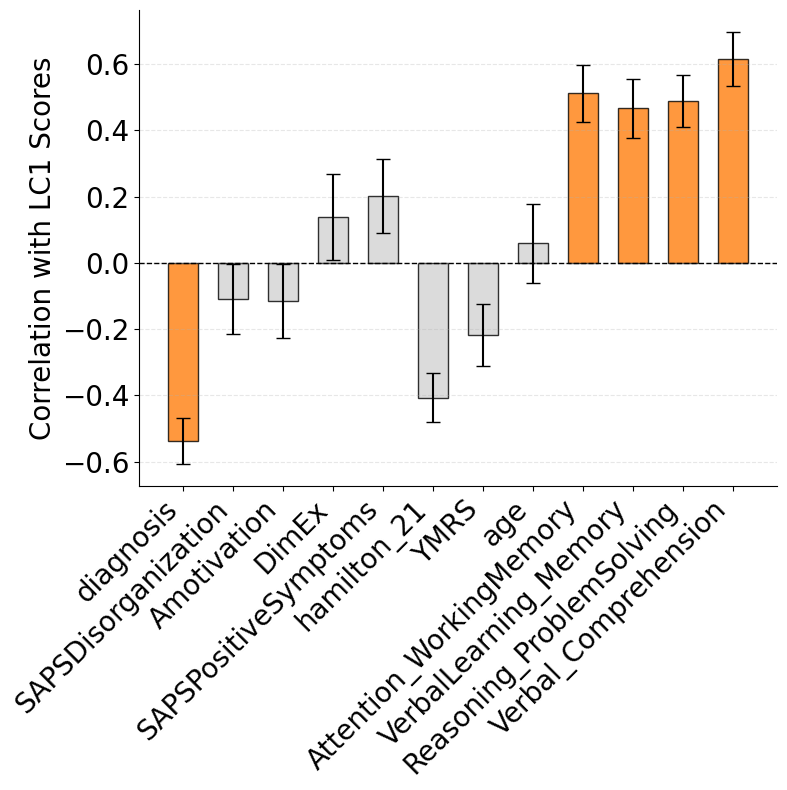

🎉 All behavioral correlation plots with error bars saved successfully!


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Settings
# =========================
n_boot = 5000
outfolder = './new_figures'

# -------------------------
# Loop over gradients
# -------------------------
for grad_name, res in results.items():
    print(f'\n=== Processing {grad_name} ===')

    # Behavioral variables
    behav_vars = list(res['behav_corrs'].keys())
    n_behav = len(behav_vars)

    # Loadings and bootstrap CI (from previous PLS loadings plot)
    Y_saliences = res['Y_saliences']
    boot_y_saliences = res['boot_y_saliences']

    # Compute 95% CI for loadings
    lower_ci = Y_saliences - 1.96 * boot_y_saliences.std(axis=0)
    upper_ci = Y_saliences + 1.96 * boot_y_saliences.std(axis=0)

    # Determine significance from loadings
    significant = (lower_ci > 0) | (upper_ci < 0)

    # Compute behavioral correlations
    X_scores = res['X_scores']
    Y_matrix = res['patient_df'][behav_vars].values
    r_obs = np.array([np.corrcoef(Y_matrix[:, i], X_scores)[0,1] for i in range(n_behav)])

    # Bootstrap correlations for error bars
    rng = np.random.default_rng(4)
    n_subj = X_scores.shape[0]
    boot_r = np.empty((n_boot, n_behav))
    for b in range(n_boot):
        idx = rng.integers(0, n_subj, size=n_subj)
        Xb = X_scores[idx]
        Yb = Y_matrix[idx, :]
        boot_r[b, :] = [np.corrcoef(Yb[:, i], Xb)[0,1] for i in range(n_behav)]

    r_std = boot_r.std(axis=0)  # standard deviation for error bars

    # -------------------------
    # Plot correlations using loadings significance + error bars
    # -------------------------
    fig, ax = plt.subplots(figsize=(8,8))
    bar_width = 0.6

    for i in range(n_behav):
        color = '#FF7F0E' if significant[i] else 'lightgrey'
        ax.bar(i, r_obs[i], color=color, edgecolor='black', width=bar_width, alpha=0.8)
        # Add error bars
        ax.errorbar(i, r_obs[i], yerr=r_std[i], fmt='none', ecolor='black', capsize=5, lw=1.5)

    # Zero line
    ax.axhline(0, color='black', linestyle='--', lw=1)

    # Axis labels & title
    ax.set_xticks(range(n_behav))
    ax.set_xticklabels(behav_vars, rotation=45, ha='right', fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel('Correlation with LC1 Scores', fontsize=20)
    #ax.set_title(f'{grad_name} — Behavioral correlations (significance from loadings)', fontsize=20, fontweight='bold')

    # Grid & spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.savefig(f'{outfolder}/{grad_name}_behavior_barplot_loadings_significance_errorbars.png', dpi=300)
    plt.show()

print("🎉 All behavioral correlation plots with error bars saved successfully!")


Global histograms + ridge (joy)
Network-level ridge plots of gradient and PLS brain distributions.
For each gradient (G1–G3), we computed the mean gradient value across parcels per network and plotted the network-level distributions of z-scored group-average gradient values (top, gray curves) and PLS brain saliences (bottom, colored curves) using kernel density estimation. Gray ridges depict the spatial embedding of cortical networks along each gradient, whereas the colored ridges (network-specific colors) represent the distribution of PLS brain loadings, indicating the contribution of each network to the latent variable. 

C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\1483341552.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno')


Processing G1...


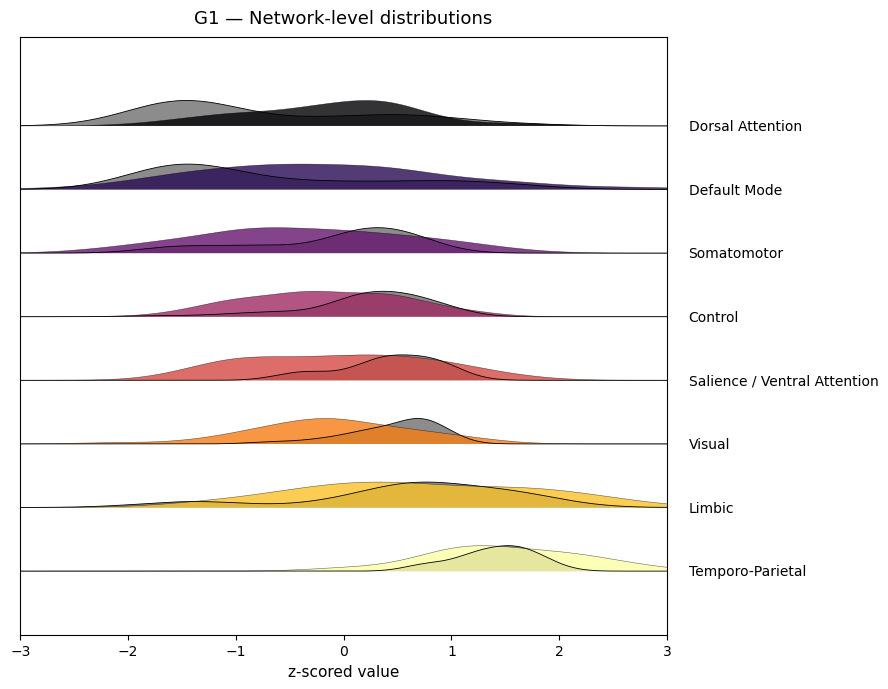

Saved ./new_figures/G1_vs_loadings.png
Processing G2...


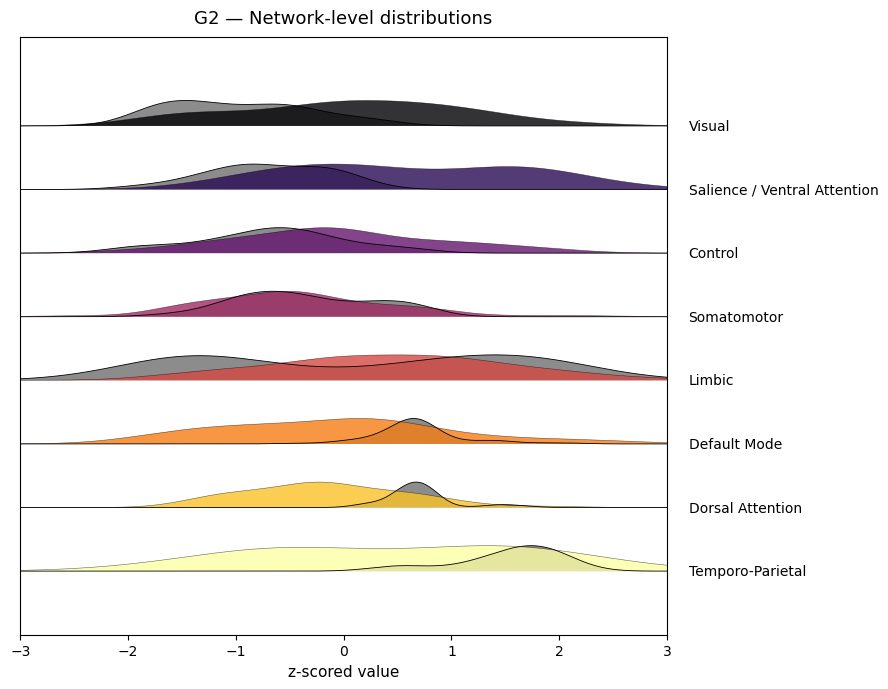

Saved ./new_figures/G2_vs_loadings.png
Processing G3...


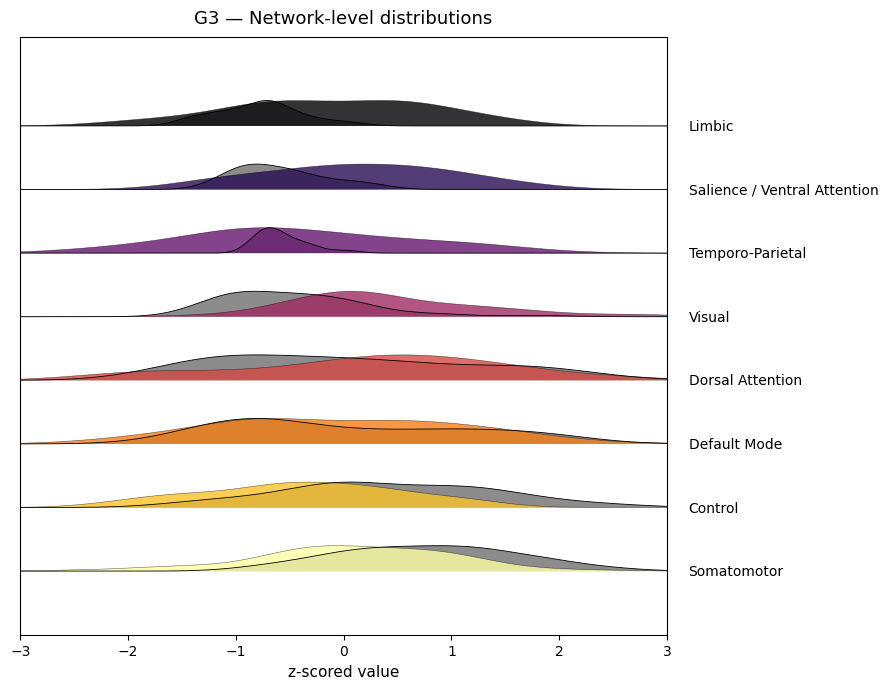

Saved ./new_figures/G3_vs_loadings.png


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import zscore, gaussian_kde

# -----------------------------
# Ridge plot for each gradient
# -----------------------------
x_min, x_max = -3, 3
x_grid = np.linspace(x_min, x_max, 400)
cmap = cm.get_cmap('inferno')
# === Load Yeo-like network assignments (second column of Excel)
networks_df = pd.read_excel('BD-SCZ/Parcels_Labels_YeoNet8.xlsx', header=None)
network_ids = networks_df.iloc[:, 1].values  # shape (400,)

# === Define network names and colors
network_names = {
    1: 'Visual',
    2: 'Somatomotor',
    3: 'Dorsal Attention',
    4: 'Salience / Ventral Attention',
    5: 'Limbic',
    6: 'Control',
    7: 'Temporo-Parietal',
    8: 'Default Mode',
}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"Processing {grad_name}...")

    grad_df = pd.read_csv(grad_file)
    grad_vals = grad_df[parcel_cols].mean(axis=0).values
    pls_vals = results[grad_name]['X_saliences']

    grad_z = zscore(grad_vals, nan_policy='omit')
    pls_z = zscore(pls_vals, nan_policy='omit')
    grad_z = np.clip(grad_z, x_min, x_max)
    pls_z = np.clip(pls_z, x_min, x_max)

    fig, ax_ridge = plt.subplots(figsize=(9, 7))

    # Sort networks by mean gradient
    net_means = {nid: np.nanmean(grad_z[network_ids == nid]) for nid in np.unique(network_ids)}
    ordered_nids = sorted(net_means, key=lambda k: net_means[k])
    n_networks = len(ordered_nids)

    # Generate ordered colors from inferno colormap
    colors = {nid: cmap(i / (n_networks - 1)) for i, nid in enumerate(ordered_nids)}

    gap = 2.0
    scale = 0.8
    offsets = np.arange(n_networks)[::-1] * gap

    for i, nid in enumerate(ordered_nids):
        idx = network_ids == nid
        label = network_names.get(nid, f'Network {nid}')
        color = colors[nid]

        grad_data = grad_z[idx]
        pls_data = pls_z[idx]

        kde_grad = gaussian_kde(grad_data)(x_grid)
        kde_grad /= kde_grad.max()
        kde_grad *= scale

        kde_pls = gaussian_kde(pls_data)(x_grid)
        kde_pls /= kde_pls.max()
        kde_pls *= scale

        y_off = offsets[i]

        # --- Both curves plotted upward ---
        # Gradient (gray)
        ax_ridge.fill_between(x_grid, y_off, y_off + kde_grad,
                              facecolor='gray', alpha=0.9, lw=0)
        ax_ridge.plot(x_grid, y_off + kde_grad, color='black', lw=0.6)

        # PLS (colored)
        ax_ridge.fill_between(x_grid, y_off, y_off + kde_pls,
                              facecolor=color, alpha=0.80, lw=0)
        ax_ridge.plot(x_grid, y_off + kde_pls, color='black', lw=0.4, alpha=0.6)

        # Label
        ax_ridge.text(x_max + 0.2, y_off, label,
                      va='center', ha='left', fontsize=10)

    ax_ridge.set_ylim(-gap, offsets[0] + gap + scale)
    ax_ridge.set_xlim(x_min, x_max)
    ax_ridge.set_yticks([])
    ax_ridge.set_xlabel('z-scored value', fontsize=11)
    ax_ridge.set_title(f'{grad_name} — Network-level distributions', fontsize=13, pad=10)

    plt.tight_layout()
    outfn = f'{outfolder}/{grad_name}_vs_loadings.png'
    plt.savefig(outfn, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    print(f"Saved {outfn}")


This figure shows network-level distributions of cortical gradients for healthy controls (HC) versus patients. It consists of two main panels:

1. Global distributions (top panel):
Kernel density estimates (KDEs) of z-scored gradient values averaged across all parcels, separately for HC (orange) and patients (purple). The curves are normalized to highlight relative density differences. 

2. Network-specific ridge plots (bottom panel):
Ridge plots show the distribution of gradient values for each functional network, based on Yeo parcellations. Upper half of each ridge: HC distribution (lighter color). Lower half of each ridge: patient distribution (solid color). Vertical lines indicate network-wise mean gradient values for each group. 


Processing G1...


C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\1024275124.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno')  # continuous color palette
C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\1024275124.py:153: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


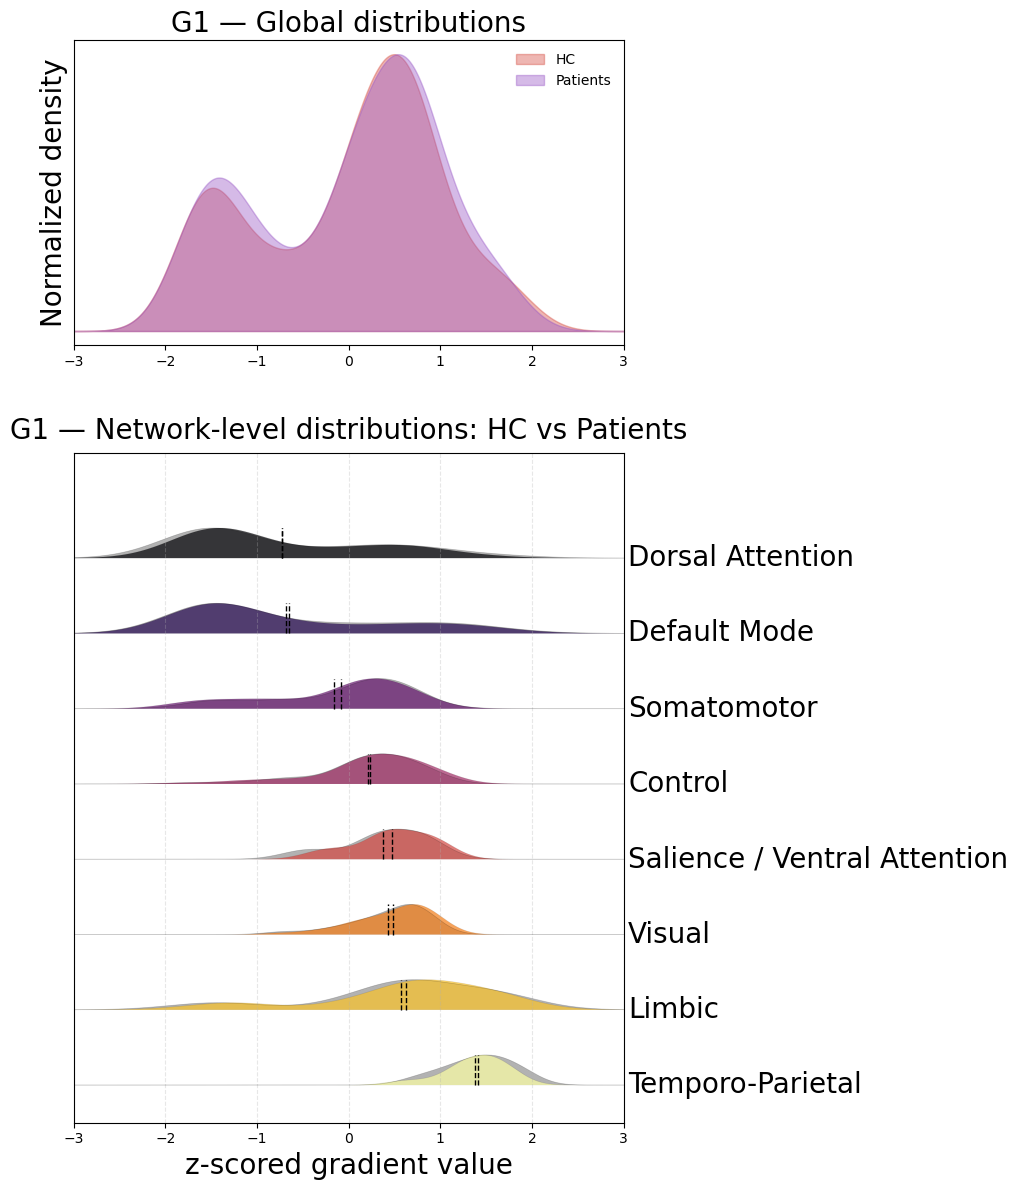

Saved ./new_figures/G1_HC_vs_patients.png

Processing G2...


C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\1024275124.py:153: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


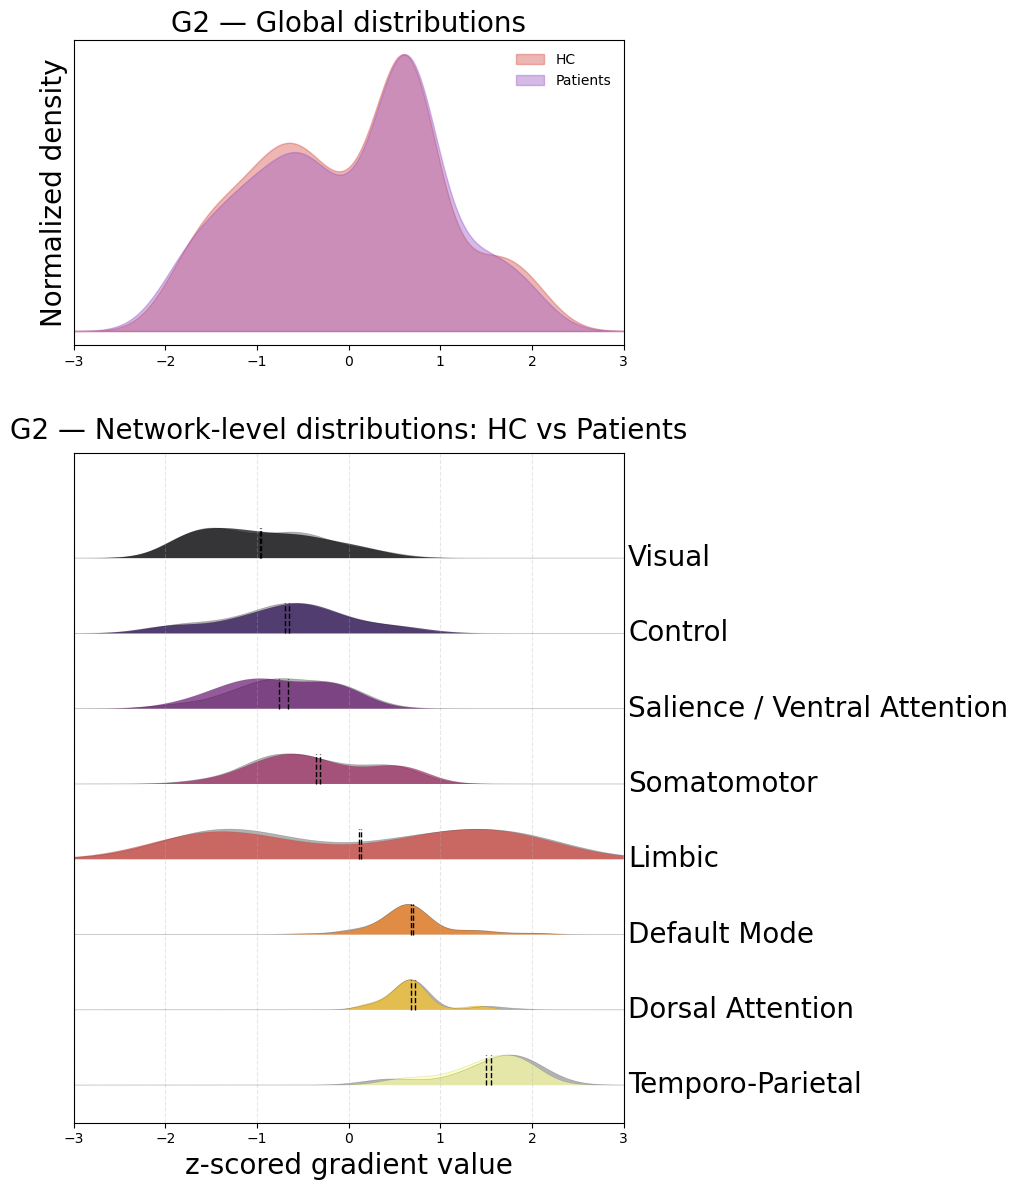

Saved ./new_figures/G2_HC_vs_patients.png

Processing G3...


C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\1024275124.py:153: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


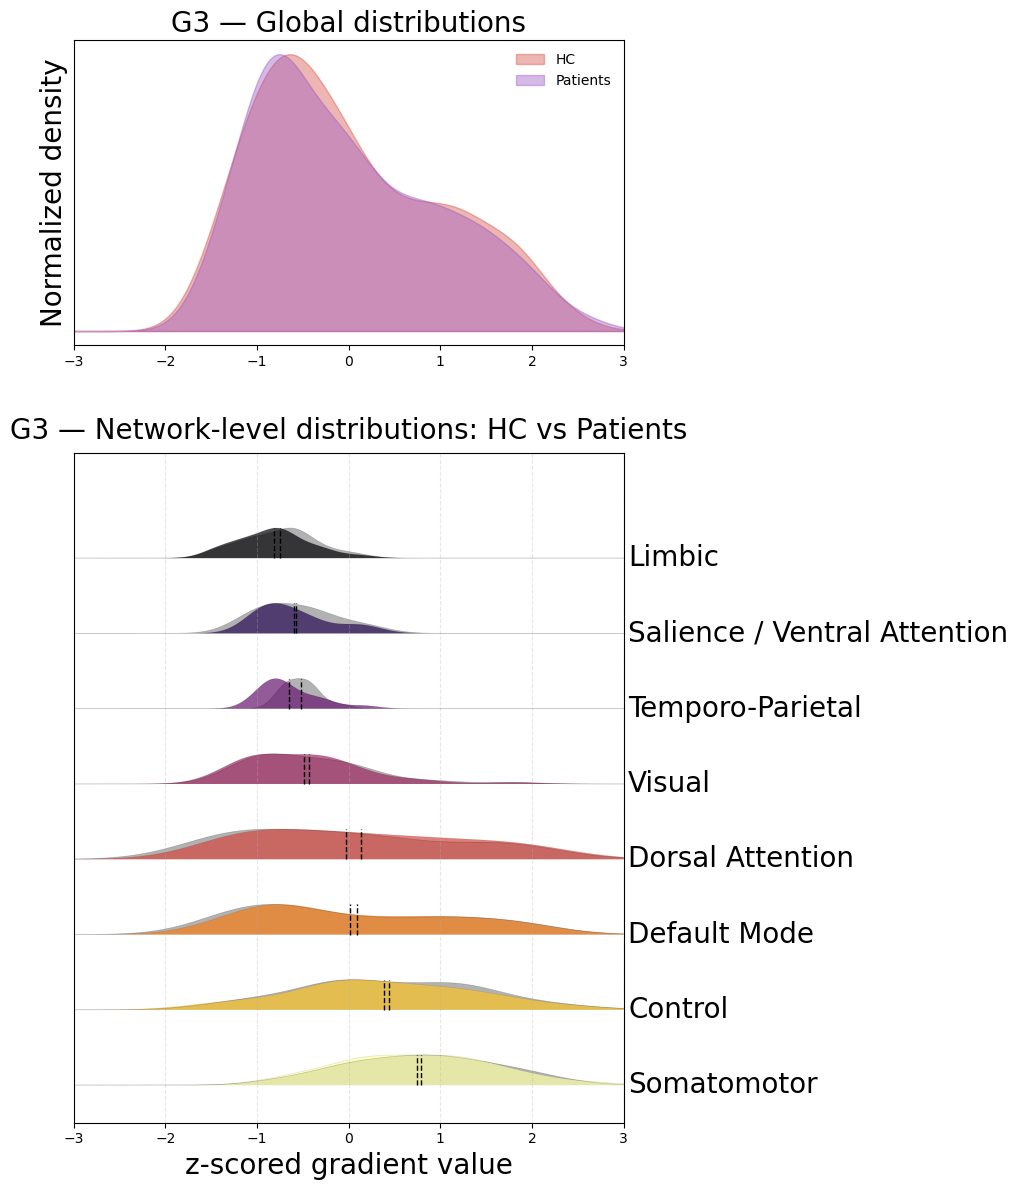

Saved ./new_figures/G3_HC_vs_patients.png


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
from matplotlib import cm

# -----------------------------
# User inputs
# -----------------------------
yeo_excel = 'BD-SCZ/Parcels_Labels_YeoNet8.xlsx'
outfolder = './new_figures'
parcel_cols = [f'node_{i+1}' for i in range(400)]

grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

network_names = {
    1: 'Visual', 2: 'Somatomotor', 3: 'Dorsal Attention', 4: 'Salience / Ventral Attention',
    5: 'Limbic', 6: 'Control', 7: 'Temporo-Parietal', 8: 'Default Mode'
}

x_min, x_max = -3, 3
x_grid = np.linspace(x_min, x_max, 501)
draw_mean_lines = True

# -----------------------------
# Load network assignments
# -----------------------------
networks_df = pd.read_excel(yeo_excel, header=None)
network_ids = networks_df.iloc[:, 1].values.astype(int)
if len(network_ids) != 400:
    raise ValueError(f"Expected 400 parcels, got {len(network_ids)}")

# -----------------------------
# Loop through gradients
# -----------------------------
cmap = cm.get_cmap('inferno')  # continuous color palette

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\nProcessing {grad_name}...")

    # Load gradient data
    df = pd.read_csv(grad_file)
    df_hc = df[df['diagnosis'] == 1].copy()
    df_pat = df[df['diagnosis'].isin([2, 3])].copy()

    # Mean across subjects per parcel
    grad_hc = df_hc[parcel_cols].mean(axis=0).values
    grad_pat = df_pat[parcel_cols].mean(axis=0).values

    # Z-score
    grad_hc_z = zscore(grad_hc, nan_policy='omit')
    grad_pat_z = zscore(grad_pat, nan_policy='omit')

    # Clip extreme values
    grad_hc_z = np.clip(grad_hc_z, x_min, x_max)
    grad_pat_z = np.clip(grad_pat_z, x_min, x_max)

    # -----------------------------
    # Global KDEs
    # -----------------------------
    fig = plt.figure(constrained_layout=True, figsize=(10, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 0.02, 2.2])
    ax_hist = fig.add_subplot(gs[0, 0])

    kde_hc = gaussian_kde(grad_hc_z)
    kde_pat = gaussian_kde(grad_pat_z)
    hc_vals = kde_hc(x_grid) / kde_hc(x_grid).max()
    pat_vals = kde_pat(x_grid) / kde_pat(x_grid).max()

    ax_hist.fill_between(x_grid, hc_vals, color='#D54A3F', alpha=0.4, label='HC')
    ax_hist.fill_between(x_grid, pat_vals, color='#9654C5', alpha=0.4, label='Patients')
    ax_hist.set_xlim(x_min, x_max)
    ax_hist.set_yticks([])
    ax_hist.set_ylabel('Normalized density', fontsize=20)
    ax_hist.set_title(f'{grad_name} — Global distributions', fontsize=20)
    ax_hist.legend(frameon=False)

    # Spacer
    _ = fig.add_subplot(gs[1,0])
    _.axis('off')

    # -----------------------------
    # Ridge plots per network
    # -----------------------------
    ax_ridge = fig.add_subplot(gs[2,0])

    # Order networks by HC mean to keep ordering consistent
    net_means = {nid: np.nanmean(grad_hc_z[network_ids==nid]) for nid in np.unique(network_ids)}
    ordered_nids = sorted(net_means, key=lambda k: net_means[k])
    n_networks = len(ordered_nids)

    # Assign colors from inferno based on order
    colors = {nid: cmap(i / (n_networks - 1)) for i, nid in enumerate(ordered_nids)}

    gap = 2.0
    scale = 0.8
    offsets = np.arange(n_networks)[::-1] * gap

    for i, nid in enumerate(ordered_nids):
        idx = network_ids == nid
        label = network_names.get(nid, f'Network {nid}')
        color = colors[nid]

        # KDEs per group
        if np.sum(idx) > 1:
            kde_hc_net = gaussian_kde(grad_hc_z[idx])
            kde_pat_net = gaussian_kde(grad_pat_z[idx])

            kde_hc_vals = kde_hc_net(x_grid)
            kde_hc_vals /= kde_hc_vals.max()
            kde_hc_vals *= scale

            kde_pat_vals = kde_pat_net(x_grid)
            kde_pat_vals /= kde_pat_vals.max()
            kde_pat_vals *= scale
        else:
            kde_hc_vals = np.zeros_like(x_grid)
            kde_pat_vals = np.zeros_like(x_grid)

        y_off = offsets[i]

        # --- Both HC and Patients facing upward ---
        # HC ridge (soft purple)
        ax_ridge.fill_between(x_grid, y_off, y_off + kde_hc_vals,
                              facecolor='grey', alpha=0.6)
        ax_ridge.plot(x_grid, y_off + kde_hc_vals, color='black', lw=0.5, alpha=0.2)

        # Patients ridge (inferno color)
        ax_ridge.fill_between(x_grid, y_off, y_off + kde_pat_vals,
                              facecolor=color, alpha=0.7)
        ax_ridge.plot(x_grid, y_off + kde_pat_vals, color='black', lw=0.5, alpha=0.1)

        # Network label
        ax_ridge.text(x_max+0.05, y_off, label, va='center', fontsize=20)

        # Mean lines
        if draw_mean_lines:
            mean_hc = np.nanmean(grad_hc_z[idx])
            mean_pat = np.nanmean(grad_pat_z[idx])
            ax_ridge.vlines(mean_hc, y_off, y_off + kde_hc_vals.max(),
                            color='black', lw=1.0, ls='--')
            ax_ridge.vlines(mean_pat, y_off, y_off + kde_pat_vals.max(),
                            color='black', lw=1.0, ls='--')

    ax_ridge.set_ylim(-gap*0.5, offsets[0] + gap + scale)
    ax_ridge.set_xlim(x_min, x_max)
    ax_ridge.set_yticks([])
    ax_ridge.set_xlabel('z-scored gradient value', fontsize=20)
    ax_ridge.set_title(f'{grad_name} — Network-level distributions: HC vs Patients', fontsize=20, pad=10)
    ax_ridge.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    outfn = f'{outfolder}/{grad_name}_HC_vs_patients.png'
    plt.savefig(outfn, dpi=3000, bbox_inches='tight', transparent=True)
    plt.show()
    print(f"Saved {outfn}")


## BD and SCZ patients comparison


Processing G1 for BPD vs SCZ comparison...


C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\2911343701.py:145: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


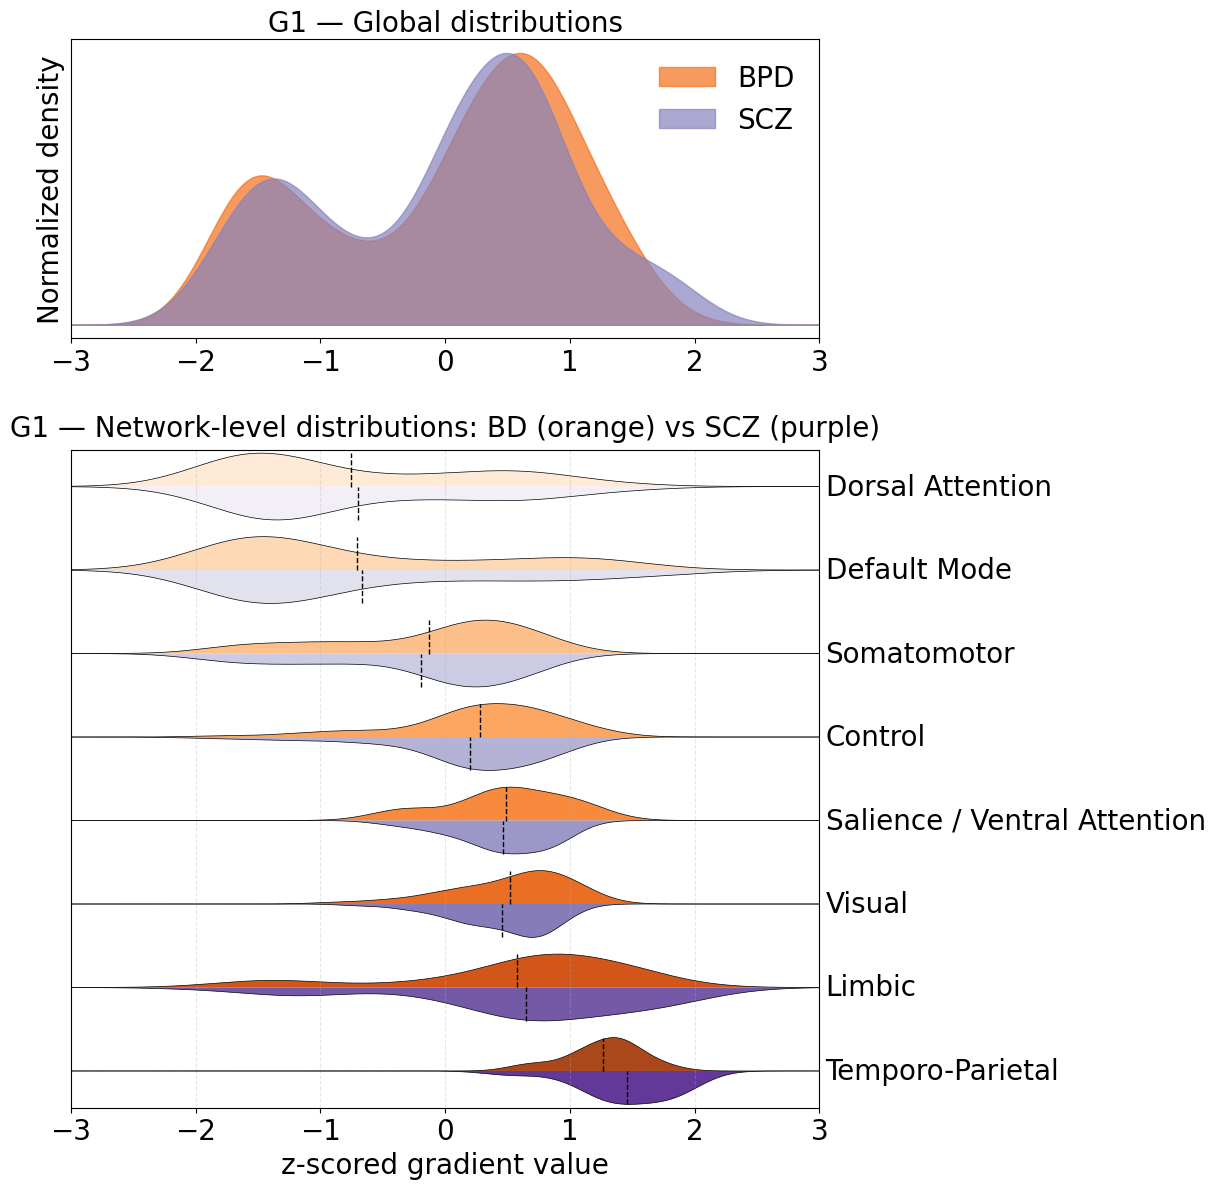

Saved ./new_figures/G1_BD_vs_SCZ.png

Processing G2 for BPD vs SCZ comparison...


C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\2911343701.py:145: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


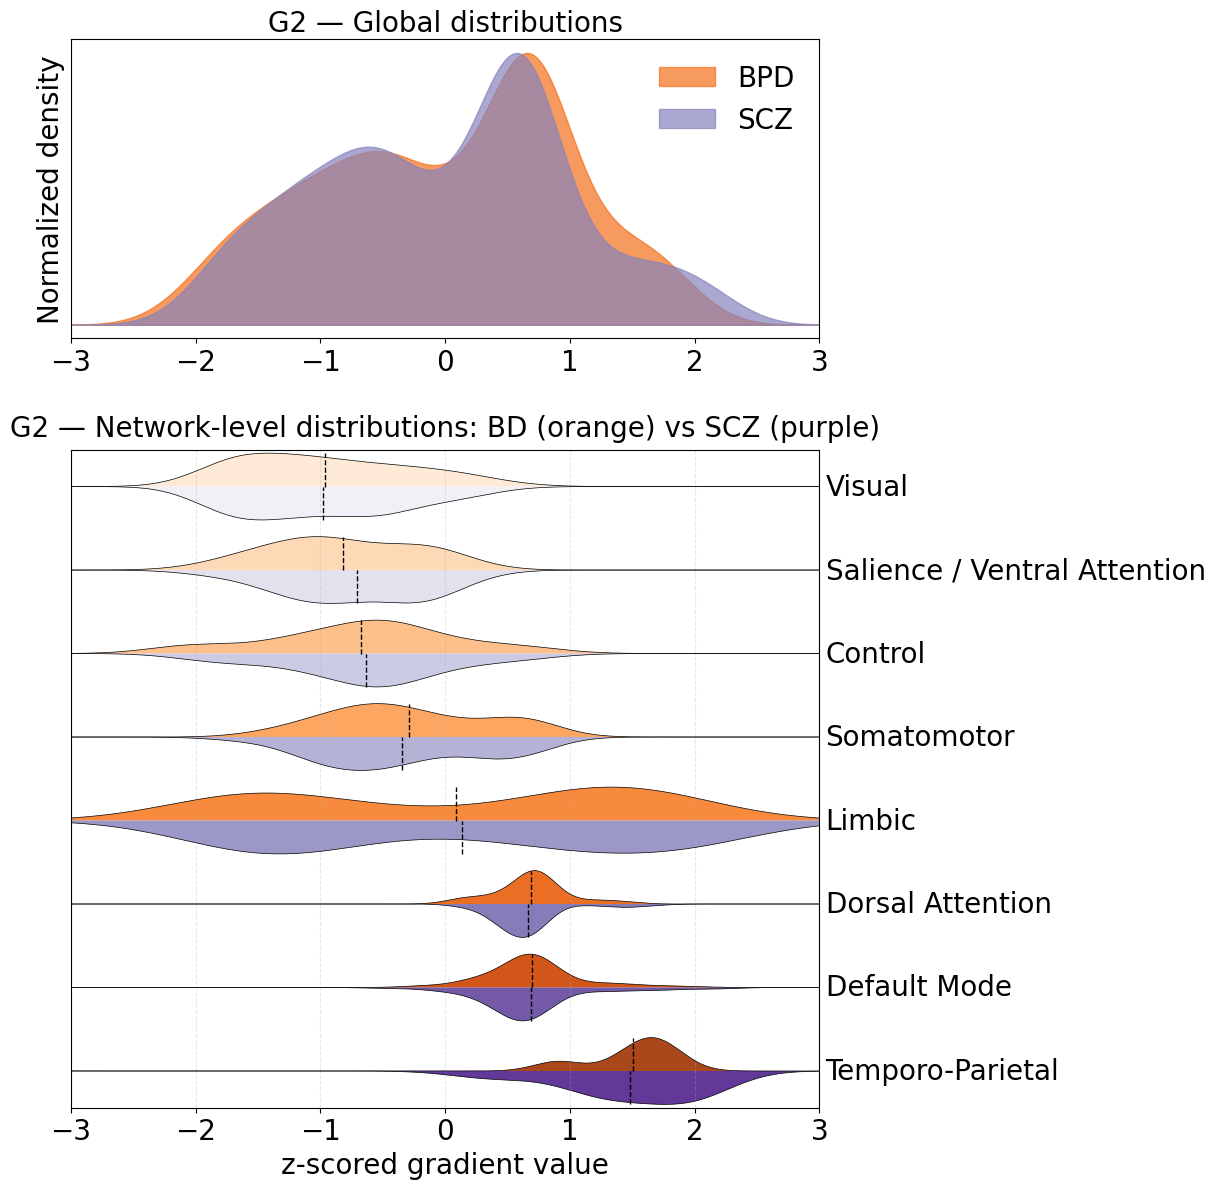

Saved ./new_figures/G2_BD_vs_SCZ.png

Processing G3 for BPD vs SCZ comparison...


C:\Users\ferraras\AppData\Local\Temp\ipykernel_17164\2911343701.py:145: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


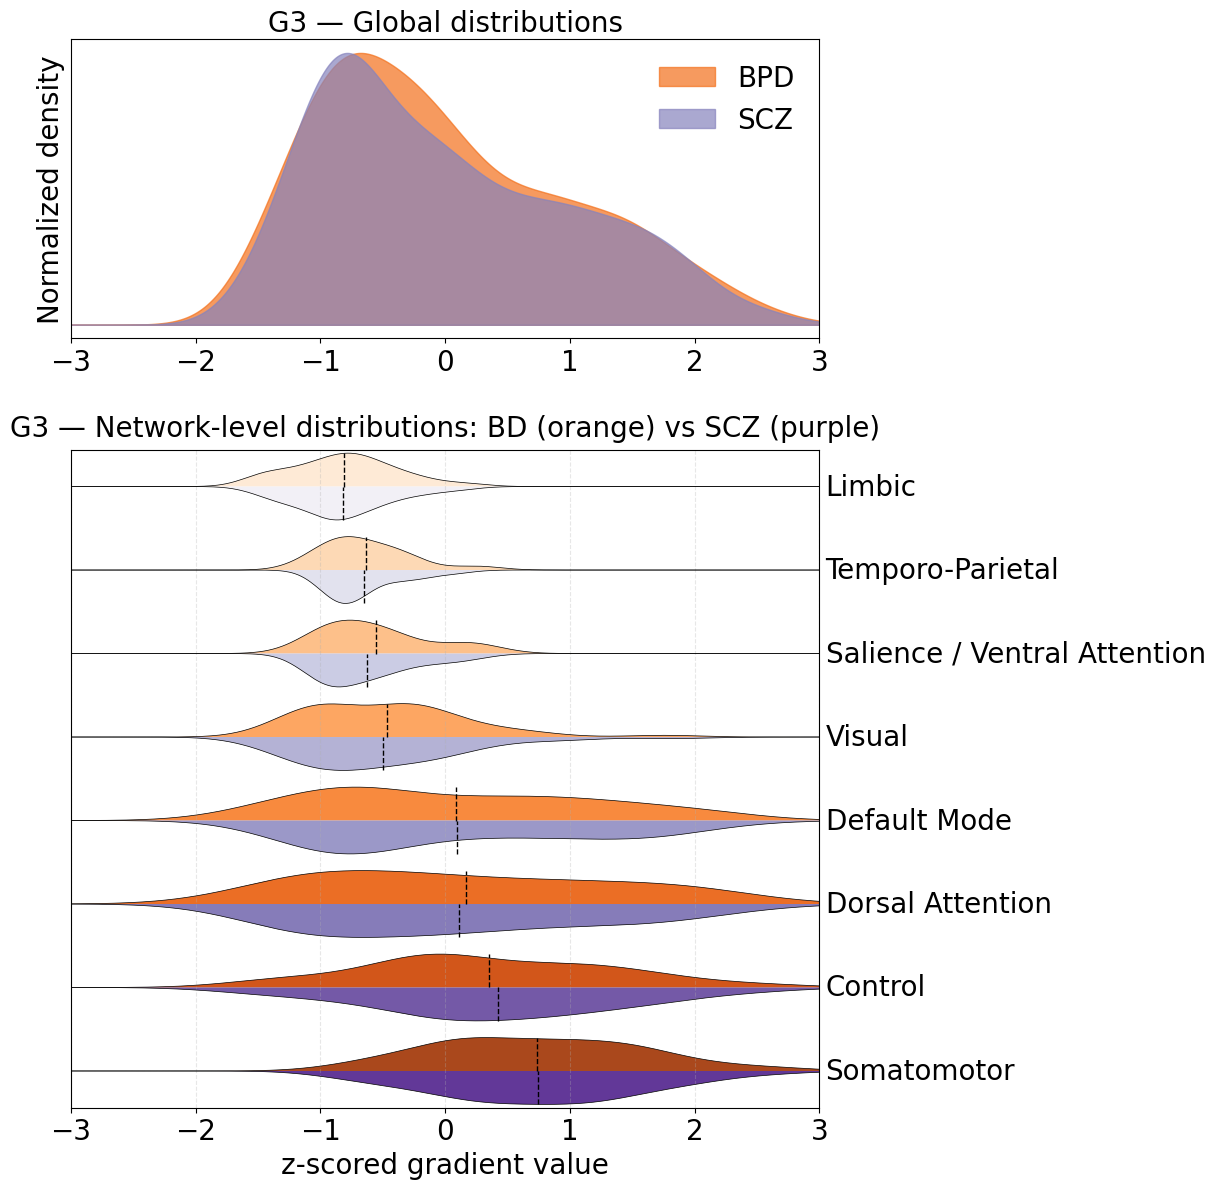

Saved ./new_figures/G3_BD_vs_SCZ.png


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
from matplotlib import cm

# -----------------------------
# User inputs
# -----------------------------
yeo_excel = 'BD-SCZ/Parcels_Labels_YeoNet8.xlsx'
outfolder = './new_figures'
parcel_cols = [f'node_{i+1}' for i in range(400)]

grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

network_names = {
    1: 'Visual', 2: 'Somatomotor', 3: 'Dorsal Attention', 4: 'Salience / Ventral Attention',
    5: 'Limbic', 6: 'Control', 7: 'Temporo-Parietal', 8: 'Default Mode'
}

x_min, x_max = -3, 3
x_grid = np.linspace(x_min, x_max, 501)
draw_mean_lines = True

# Colormaps for groups
cmap_bd = cm.Oranges
cmap_scz = cm.Purples

# -----------------------------
# Load network assignments
# -----------------------------
networks_df = pd.read_excel(yeo_excel, header=None)
network_ids = networks_df.iloc[:, 1].values.astype(int)
if len(network_ids) != 400:
    raise ValueError(f"Expected 400 parcels, got {len(network_ids)}")

# -----------------------------
# Loop through gradients
# -----------------------------
for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\nProcessing {grad_name} for BPD vs SCZ comparison...")

    # Load gradient data
    df = pd.read_csv(grad_file)
    df_bd = df[df['diagnosis'] == 2].copy()
    df_scz = df[df['diagnosis'] == 3].copy()

    # Mean across subjects per parcel
    grad_bd = df_bd[parcel_cols].mean(axis=0).values
    grad_scz = df_scz[parcel_cols].mean(axis=0).values

    # Z-score and clip
    grad_bd_z = np.clip(zscore(grad_bd, nan_policy='omit'), x_min, x_max)
    grad_scz_z = np.clip(zscore(grad_scz, nan_policy='omit'), x_min, x_max)

    # -----------------------------
    # Global KDEs
    # -----------------------------
    fig = plt.figure(constrained_layout=True, figsize=(12, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 0.02, 2.2])
    ax_hist = fig.add_subplot(gs[0, 0])

    kde_bd = gaussian_kde(grad_bd_z)
    kde_scz = gaussian_kde(grad_scz_z)
    bd_vals = kde_bd(x_grid) / kde_bd(x_grid).max()
    scz_vals = kde_scz(x_grid) / kde_scz(x_grid).max()

    ax_hist.fill_between(x_grid, bd_vals, color=cmap_bd(0.6), alpha=0.7, label='BPD')
    ax_hist.fill_between(x_grid, scz_vals, color=cmap_scz(0.6), alpha=0.7, label='SCZ')
    ax_hist.set_xlim(x_min, x_max)
    ax_hist.set_yticks([])
    ax_hist.set_ylabel('Normalized density', fontsize=20)
    ax_hist.set_title(f'{grad_name} — Global distributions', fontsize=20)
    ax_hist.tick_params(axis='x', labelsize=20)
    ax_hist.legend(frameon=False, fontsize=20)

    # Spacer
    _ = fig.add_subplot(gs[1, 0])
    _.axis('off')

    # -----------------------------
    # Ridge plots per network
    # -----------------------------
    ax_ridge = fig.add_subplot(gs[2, 0])

    # Sort networks by BD mean
    net_means = {nid: np.nanmean(grad_bd_z[network_ids == nid]) for nid in np.unique(network_ids)}
    ordered_nids = sorted(net_means, key=lambda k: net_means[k])
    n_networks = len(ordered_nids)

    gap = 2.0
    scale = 0.8
    # Symmetric offsets around zero to remove large gaps
    offsets = np.linspace((n_networks-1)/2*gap, -(n_networks-1)/2*gap, n_networks)

    for i, nid in enumerate(ordered_nids):
        idx = network_ids == nid
        label = network_names.get(nid, f'Network {nid}')

        color_bd = cmap_bd((i+1)/(n_networks+1))
        color_scz = cmap_scz((i+1)/(n_networks+1))

        if np.sum(idx) > 1:
            kde_bd_vals = gaussian_kde(grad_bd_z[idx])(x_grid)
            kde_bd_vals /= kde_bd_vals.max()
            kde_bd_vals *= scale

            kde_scz_vals = gaussian_kde(grad_scz_z[idx])(x_grid)
            kde_scz_vals /= kde_scz_vals.max()
            kde_scz_vals *= scale
        else:
            kde_bd_vals = np.zeros_like(x_grid)
            kde_scz_vals = np.zeros_like(x_grid)

        y_off = offsets[i]

        # BD ridge (upward)
        ax_ridge.fill_between(x_grid, y_off, y_off + kde_bd_vals, facecolor=color_bd, alpha=0.9)
        ax_ridge.plot(x_grid, y_off + kde_bd_vals, color='black', lw=0.5)

        # SCZ ridge (downward)
        ax_ridge.fill_between(x_grid, y_off - kde_scz_vals, y_off, facecolor=color_scz, alpha=0.9)
        ax_ridge.plot(x_grid, y_off - kde_scz_vals, color='black', lw=0.5)

        # Network label
        ax_ridge.text(x_max + 0.05, y_off, label, va='center', fontsize=20)

        # Mean lines
        if draw_mean_lines:
            ax_ridge.vlines(np.nanmean(grad_bd_z[idx]), y_off, y_off + kde_bd_vals.max(),
                            color='black', lw=1.0, ls='--')
            ax_ridge.vlines(np.nanmean(grad_scz_z[idx]), y_off - kde_scz_vals.max(), y_off,
                            color='black', lw=1.0, ls='--')

    ax_ridge.set_ylim(offsets[-1] - scale*1.1, offsets[0] + scale*1.1)
    ax_ridge.set_xlim(x_min, x_max)
    ax_ridge.set_yticks([])
    ax_ridge.set_xlabel('z-scored gradient value', fontsize=20)
    ax_ridge.set_title(f'{grad_name} — Network-level distributions: BD (orange) vs SCZ (purple)',
                       fontsize=20, pad=10)
    ax_ridge.tick_params(axis='x', labelsize=20)
    ax_ridge.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    outfn = f'{outfolder}/{grad_name}_BD_vs_SCZ.png'
    plt.savefig(outfn, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    print(f"Saved {outfn}")
